![title](MAIN_BANNER.png)

# Toxic Comment Classification Challenge

## 1. Business Problem

### 1.1 Description

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this Case Study, we are challenged to build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

Source : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

### 1.2 Problem Statemtent

Detection of different types of toxic comments and classify them in different classes like Toxic, Severe_Toxic, Obscene, Threat, Insult and Identity_Hate.But a Single comment can be classified in multiple classes.
So it is a Multilabel Classification Problem.

### 1.3 Data Description

We are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

A. Toxic; 
B. Severe_Toxic; 
C. Obscene; 
D. Threat; 
E. Insult; 
F. Identity_Hate.

### 1.4 File Description

train.csv - the training set, contains comments with their binary labels.

test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.

sample_submission.csv - a sample submission file in the correct format.

test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring.

### 1.5 Usage

The dataset under CC0, with the underlying comment text being governed by Wikipedia's CC-SA-3.0

### 1.6 Real-world/Business objectives and constraints

1. The cost of a mis-classification can be very high.
2. No strict latency concerns.
3. Determining a comment toxic or not is highly subjective from person to person.

## Exploratory Data Analysis

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import warnings
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings("ignore")

### Reading data and Basic stats

In [2]:
train_df = pd.read_csv('train.csv')
print('Number of data points : ', train_df.shape[0])
print('Number of features : ', train_df.shape[1])
print('Features : ', train_df.columns.values)
train_df.head(10)

Number of data points :  159571
Number of features :  8
Features :  ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [3]:
train_df.shape

(159571, 8)

In [4]:
print("Check for missing values in Train dataset")
missing_values_check = train_df.isnull().sum()
print(missing_values_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [5]:
test_df = pd.read_csv('test.csv')
print('Number of data points : ', test_df.shape[0])
print('Number of features : ', test_df.shape[1])
print('Features : ', test_df.columns.values)
test_df.head(10)

Number of data points :  153164
Number of features :  2
Features :  ['id' 'comment_text']


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [6]:
test_df.shape

(153164, 2)

In [7]:
print("Check for missing values in Train dataset")
missing_values_check = test_df.isnull().sum()
print(missing_values_check)

Check for missing values in Train dataset
id              0
comment_text    0
dtype: int64


In [8]:
x = train_df.iloc[:,2:].sum()
rowsums = train_df.iloc[:,2:].sum(axis=1)
clean_comments_count = (rowsums==0).sum(axis=0)
train_df['clean']=(rowsums==0)
train_df['clean'].sum()
print("Total number of Comments = ",len(train_df))
print("Total number of Clean Comments = ",train_df['clean'].sum())
print("Total number of Tags =",x.sum())
print("Total number of Comments with labels =",(len(train_df)-clean_comments_count))

Total number of Comments =  159571
Total number of Clean Comments =  143346
Total number of Tags = 35098
Total number of Comments with labels = 16225


In [9]:
comments = train_df['comment_text']
print(comments.head())
comments = comments.as_matrix()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object


In [10]:
categories = train_df[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']]
print(categories.head(10))
categories = categories.as_matrix()

   toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0              0
1      0             0        0       0       0              0
2      0             0        0       0       0              0
3      0             0        0       0       0              0
4      0             0        0       0       0              0
5      0             0        0       0       0              0
6      1             1        1       0       1              0
7      0             0        0       0       0              0
8      0             0        0       0       0              0
9      0             0        0       0       0              0


In [11]:
count1,count2 = 0,0
for i in range(categories.shape[0]):
    count = np.count_nonzero(categories[i])
    if count :
        count1 = count1+1
    if count > 1 :
        count2 = count2+1
print('Comments having atleast belongs to One Category : ',count1)
print('Comments having atleast belongs to Two or more Categories : ',count2)

Comments having atleast belongs to One Category :  16225
Comments having atleast belongs to Two or more Categories :  9865


average length of comment: 394.073


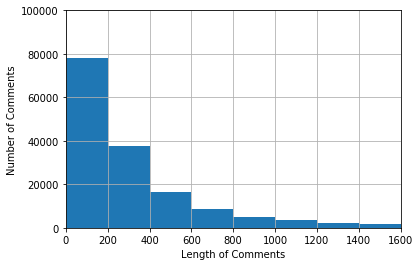

In [12]:
x = [len(comments[i]) for i in range(comments.shape[0])]
print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200,1400,1600]
plt.hist(x, bins=bins)
plt.xlabel('Length of Comments')
plt.ylabel('Number of Comments')       
plt.axis([0, 1600, 0, 100000])
plt.grid(True)
plt.show()

In [13]:
#Sentence count in each comment: '\n' is split & count number of sentences in each comment
train_df['count_sent'] = train_df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
train_df['count_word'] = train_df["comment_text"].apply(lambda x: len(str(x).split()))

#Unique word count:
train_df['count_unique_word'] = train_df["comment_text"].apply(lambda x: len(set(str(x).split())))

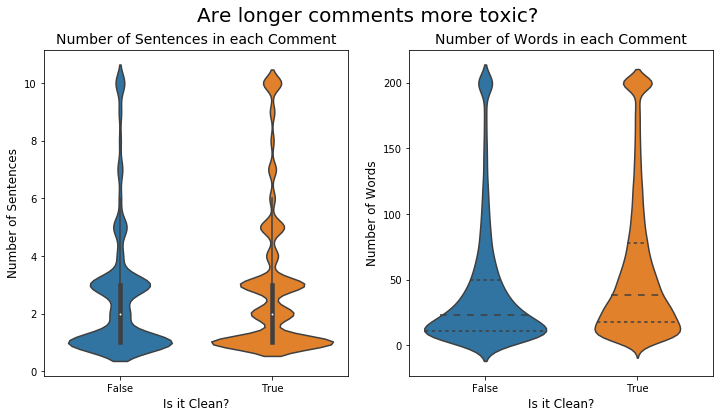

In [14]:
#https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
train_df['count_sent'].loc[train_df['count_sent']>10] = 10
plt.figure(figsize=(12,6))

# Sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_df,split=True)
plt.xlabel('Is it Clean?', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)
plt.title("Number of Sentences in each Comment", fontsize=14)

# Words
train_df['count_word'].loc[train_df['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_df,split=True,inner="quart")
plt.xlabel('Is it Clean?', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.title("Number of Words in each Comment", fontsize=14)
plt.show()

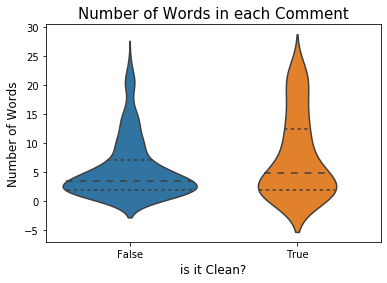

In [15]:
# clac unique word count percent in each comment:
train_df['word_unique_percent'] = train_df['count_unique_word']*100/train_df['count_word']

# lets have a look at some comments with unique word count percentage < 25%...they can be spam/referal links/marketing
# words
sns.violinplot(y = 'word_unique_percent',x='clean', data = train_df[train_df['word_unique_percent'] < 25], 
               split=True,inner="quart")
plt.xlabel('is it Clean?', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.title("Number of Words in each Comment", fontsize=15)
plt.show()

#### Barplot

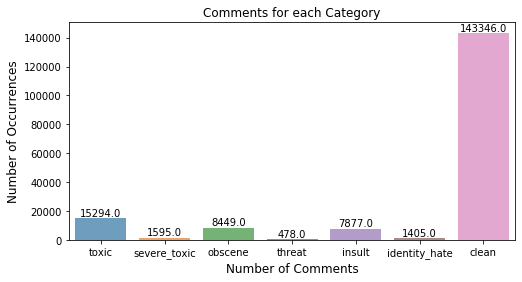

In [26]:
label_counts = train_df.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax = sns.barplot(label_counts.index, label_counts.values, alpha=0.7)
plt.title("Comments for each Category")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Comments', fontsize=12)
rects = ax.patches
labels = label_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, 
            label, ha='center', va='bottom')
plt.show()

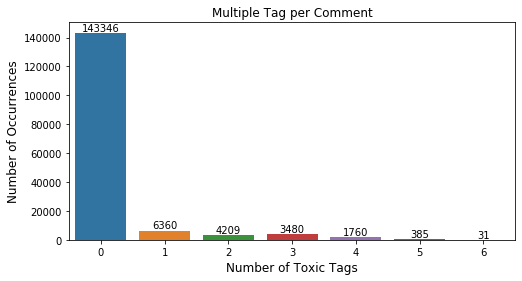

In [11]:
x = rowsums.value_counts()
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple Tag per Comment")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Toxic Tags', fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

#### Pie-Chart

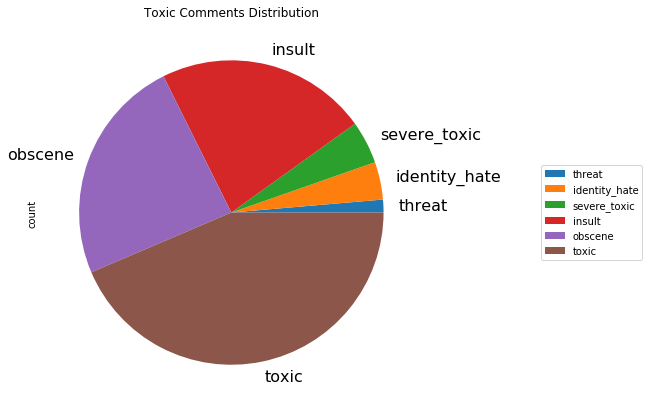

In [12]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_distribution = train_df[categories].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')

df_distribution.plot.pie(y='count', title='Toxic Comments Distribution',fontsize=16,figsize=(7, 7))\
                                                                      .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

#### Confusion Matrix

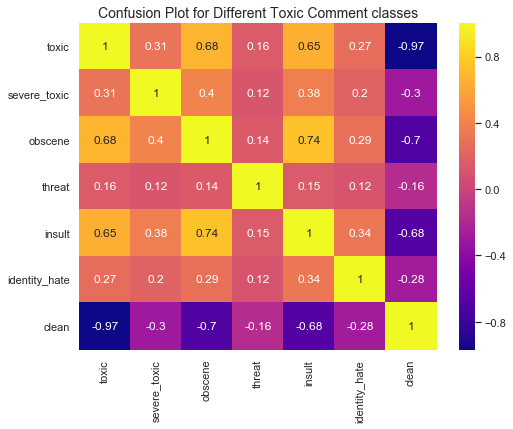

In [80]:
colormap = plt.cm.plasma
temp_df=train_df[categories]
corr=temp_df.corr()
plt.figure(figsize=(8,6))
plt.title('Confusion Plot for Different Toxic Comment classes',fontsize = 14)
sns.heatmap(corr[categories],cmap=colormap, linecolor='white',annot=True)

#### Example of Toxic Comments

In [174]:
print(train_df[train_df.toxic==1].iloc[7,1])

Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!


#### Word Cloud for Toxic Comments

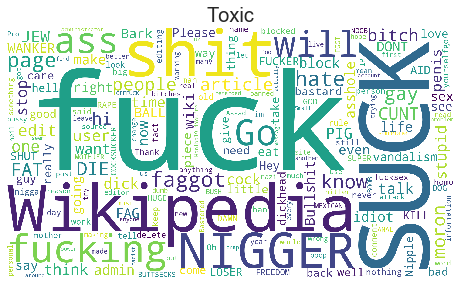

In [103]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(8,6))
subset = train_df[train_df.toxic==1]
text = subset.comment_text.values
cloud_toxic = WordCloud(stopwords=STOPWORDS, background_color='white', collocations=False, width=1920, height=1080).generate(" ".join(text))
plt.axis('off')
plt.title("Toxic",fontsize=20)
plt.imshow(cloud_toxic)

#### Example of Severe Toxic Comments

In [175]:
print(train_df[train_df.severe_toxic==1].iloc[4,1])

What a motherfucking piece of crap those fuckheads for blocking us!


#### Word Cloud for Severe Toxic Comments

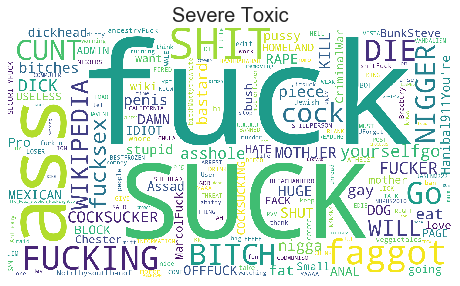

In [110]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(8,6))
subset = train_df[train_df.severe_toxic==1]
text = subset.comment_text.values
cloud_severe_toxic = WordCloud(stopwords=STOPWORDS, background_color='white', collocations=False, width=1920, height=1080
                                                                                              ).generate(" ".join(text))
plt.axis('off')
plt.title("Severe Toxic",fontsize=20)
plt.imshow(cloud_severe_toxic)

#### Example of Obscene Comments

In [176]:
print(train_df[train_df.obscene==1].iloc[3,1])

GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!


#### Word Cloud for Obscene Comments

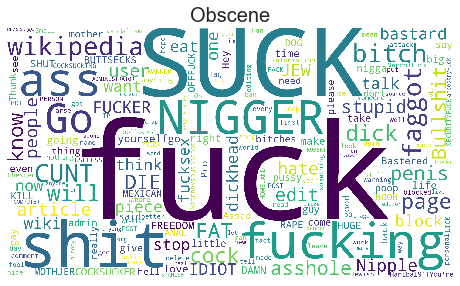

In [146]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(8,6))
subset = train_df[train_df.obscene==1]
text = subset.comment_text.values
cloud_obscene = WordCloud(stopwords=STOPWORDS, background_color='white', collocations=False, width=1920, height=1080
                                                                                              ).generate(" ".join(text))
plt.axis('off')
plt.title("Obscene",fontsize=20)
plt.imshow(cloud_obscene)

#### Example of Threat Comments

In [177]:
print(train_df[train_df.threat==1].iloc[5,1])

Whoever put a notices on my page. I will kill u


#### Word Cloud for Threat Comments

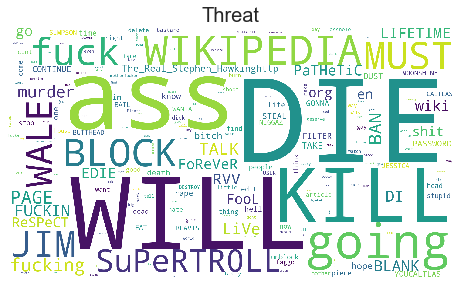

In [147]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(8,6))
subset = train_df[train_df.threat==1]
text = subset.comment_text.values
cloud_threat = WordCloud(stopwords=STOPWORDS, background_color='white', collocations=False, width=1920, height=1080
                                                                                              ).generate(" ".join(text))
plt.axis('off')
plt.title("Threat",fontsize=20)
plt.imshow(cloud_threat)

#### Example of Insult Comments

In [178]:
print(train_df[train_df.insult==1].iloc[9,1])

I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


#### Word Cloud for Insult Comments

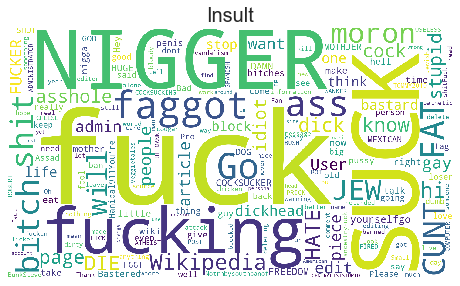

In [148]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(8,6))
subset = train_df[train_df.insult==1]
text = subset.comment_text.values
cloud_insult = WordCloud(stopwords=STOPWORDS, background_color='white', collocations=False, width=1920, height=1080
                                                                                              ).generate(" ".join(text))
plt.axis('off')
plt.title("Insult",fontsize=20)
plt.imshow(cloud_insult)

#### Example of Identity Hate Comments

In [179]:
print(train_df[train_df.identity_hate==1].iloc[24,1])

You fascit Nazi! You socialist bastard! You filthy Hippy! 

You dare touch my edits again and I'll go to where you live and kick your ass in person. It shouldn't be hard to find. Communes smell worse than slaughter houses. I make edits. I don't vandilaze. Get off your high horse.


#### Word Cloud for Identity Hate Comments

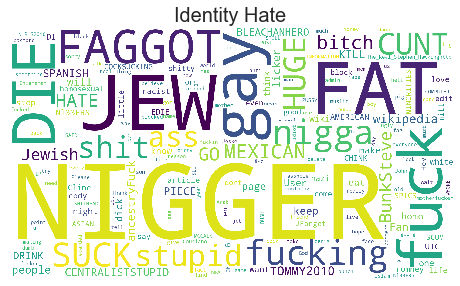

In [149]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(8,6))
subset = train_df[train_df.identity_hate==1]
text = subset.comment_text.values
cloud_identity_hate = WordCloud(stopwords=STOPWORDS, background_color='white', collocations=False, width=1920, height=1080).generate(" ".join(text))
plt.axis('off')
plt.title("Identity Hate",fontsize=20)
plt.imshow(cloud_identity_hate)
plt.show()

## Data Pre-Processing

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [14]:
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [15]:
train_df['comment_text'] = train_df['comment_text'].str.lower()
train_df['comment_text'] = train_df['comment_text'].apply(cleanHtml)
train_df['comment_text'] = train_df['comment_text'].apply(cleanPunc)
train_df['comment_text'] = train_df['comment_text'].apply(keepAlpha)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,True
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,more i cant make any real suggestions on impro...,0,0,0,0,0,0,True
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,True


In [16]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

train_df['comment_text'] = train_df['comment_text'].apply(removeStopWords)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation edits made username hardcore m...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,daww matches background colour im seemingly ...,0,0,0,0,0,0,True
2,000113f07ec002fd,hey man im really trying edit war guy c...,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,cant make real suggestions improvement ...,0,0,0,0,0,0,True
4,0001d958c54c6e35,sir hero chance remember page thats on,0,0,0,0,0,0,True


In [17]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train_df['comment_text'] = train_df['comment_text'].apply(stemming)
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,daww match background colour im seem stuck tha...,0,0,0,0,0,0,True
2,000113f07ec002fd,hey man im realli tri edit war guy constant re...,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,cant make real suggest improv wonder section s...,0,0,0,0,0,0,True
4,0001d958c54c6e35,sir hero chanc rememb page that on,0,0,0,0,0,0,True
5,00025465d4725e87,congratul well use tool well talk,0,0,0,0,0,0,True
6,0002bcb3da6cb337,cocksuck piss around work,1,1,1,0,1,0,False
7,00031b1e95af7921,vandal matt shirvington articl revert pleas do...,0,0,0,0,0,0,True
8,00037261f536c51d,sorri word nonsens offens anyway im intend wri...,0,0,0,0,0,0,True
9,00040093b2687caa,align subject contrari dulithgow,0,0,0,0,0,0,True


In [18]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
import re
def decontracted(phrase):
# specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
import itertools
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_comments = []
for sentence in tqdm(train_df['comment_text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    #https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/
    # This removes words such as aawwww or happpyyy or awsooommmee etc
    sentence = ''.join(''.join(s)[:2] for _, s in itertools.groupby(sentence))
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_comments.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [02:34<00:00, 1030.13it/s]


In [21]:
preprocessed_comments[10]

'fair use rational imag wonju jpg thank upload imag wonju jpg notic imag page specifi imag use fair use explan rational use wikipedia articl constitut fair use addit boilerpl fair use templat must write imag descript page specif explan rational use imag articl consist fair use pleas go imag descript page edit includ fair use rational upload fair use media consid check specifi fair use rational page find list imag page edit click contribut link locat top wikipedia page log select imag dropdown box note fair use imag upload lack explan delet week upload describ criteria speedi delet question pleas ask media copyright question page thank talk contrib unspecifi sourc imag wonju jpg thank upload imag wonju jpg notic file descript page current doesnt specifi creat content copyright status unclear creat file need specifi owner copyright obtain websit link websit taken togeth restat websit term use content usual suffici inform copyright holder differ websit publish copyright acknowledg well ad

### BOW

In [22]:
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_comments)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
final_counts = count_vect.transform(preprocessed_comments)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aab', 'aaba', 'aabov', 'aaboyz', 'aac', 'aacargo', 'aacd', 'aacfo', 'aachen']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (159571, 135483)
the number of unique words  135483


In [23]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_comments)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (159571, 5000)
the number of unique words including both unigrams and bigrams  5000


### TF-IDF

In [24]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_comments)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
final_tf_idf = tf_idf_vect.transform(preprocessed_comments)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aah', 'aap', 'aardvark', 'aaron', 'ab', 'aba', 'abandon', 'abba', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (159571, 67565)
the number of unique words including both unigrams and bigrams  67565


In [25]:
text_col = ['comment_text']

In [26]:
drop_col = ['id', 'clean','count_sent', 'count_word', 'count_unique_word', 'word_unique_percent']
label_col = [col for col in train_df.columns if col not in text_col + drop_col]
label_col

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [27]:
final_tf_idf = tf_idf_vect.transform(preprocessed_comments)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import scipy

features = text_col

X_test = test_df[features].copy()


X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[label_col], test_size=0.2, random_state=2019)

X_train = tf_idf_vect.transform(X_train['comment_text'])
X_val = tf_idf_vect.transform(X_val['comment_text'])
X_test = tf_idf_vect.transform(X_test['comment_text'])
feature_names = tf_idf_vect.get_feature_names()

print('Text Data dimensions after transformations:', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Text Data dimensions after transformations: (127656, 67565) (127656, 6) (31915, 67565) (31915, 6)


## ML Models

### Multinomial Naive Bayes

In [41]:
sub_df_mnb = pd.read_csv('sample_submission.csv')

In [42]:
%%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss, roc_auc_score
model = MultinomialNB(alpha = 0.1)

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_df), len(label_col)))

for i, label_name in enumerate(label_col):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))

sub_df_mnb.iloc[:,1:] = preds_test


Class:= toxic
Train ROC AUC: 0.9837999890058676
Valid ROC AUC: 0.95258538123471

Class:= severe_toxic
Train ROC AUC: 0.9929256721203312
Valid ROC AUC: 0.9727484488685235

Class:= obscene
Train ROC AUC: 0.9891218852821394
Valid ROC AUC: 0.9583701330934271

Class:= threat
Train ROC AUC: 0.9941090939418463
Valid ROC AUC: 0.9143511878613547

Class:= insult
Train ROC AUC: 0.9880679814614697
Valid ROC AUC: 0.9570413288477672

Class:= identity_hate
Train ROC AUC: 0.9896728307754585
Valid ROC AUC: 0.9400402792733558

mean column-wise ROC AUC on Train data:  0.9896162420978522
mean column-wise ROC AUC on Val data: 0.9491894598631898
Wall time: 1.36 s


In [43]:
sub_df_mnb.to_csv('submission_mnb.csv')
sub_df_mnb.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.994549,0.100258,0.988490,0.003142,0.966735,0.133749
1,0000247867823ef7,0.019381,0.000291,0.002617,0.000048,0.004957,0.000265
2,00013b17ad220c46,0.095342,0.009902,0.052453,0.003008,0.048991,0.008523
3,00017563c3f7919a,0.049306,0.000462,0.006277,0.000058,0.008894,0.000252
4,00017695ad8997eb,0.067329,0.001883,0.031952,0.000311,0.028648,0.001335


### Logistic Regression

In [44]:
sub_df_lr = pd.read_csv('sample_submission.csv')

In [45]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
model = LogisticRegression(C=10)

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_df), len(label_col)))

for i, label_name in enumerate(label_col):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))

sub_df_lr.iloc[:,1:] = preds_test


Class:= toxic
Train ROC AUC: 0.9977809251176465
Valid ROC AUC: 0.9684383390198846

Class:= severe_toxic
Train ROC AUC: 0.998277113281685
Valid ROC AUC: 0.9789279611536071

Class:= obscene
Train ROC AUC: 0.998537544674464
Valid ROC AUC: 0.979806780597173

Class:= threat
Train ROC AUC: 0.9998691491778762
Valid ROC AUC: 0.9724741857210581

Class:= insult
Train ROC AUC: 0.9973256324532058
Valid ROC AUC: 0.9690903080218426

Class:= identity_hate
Train ROC AUC: 0.9990102862922791
Valid ROC AUC: 0.9659096241166882

mean column-wise ROC AUC on Train data:  0.9984667751661928
mean column-wise ROC AUC on Val data: 0.9724411997717088
Wall time: 26.7 s


In [46]:
sub_df_lr.to_csv('submission_lr.csv')
sub_df_lr.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999866,0.181122,0.999894,0.054551,0.980881,0.145335
1,0000247867823ef7,0.001631,0.001426,0.000558,0.000264,0.004205,0.000699
2,00013b17ad220c46,0.025656,0.002647,0.006197,0.000660,0.008454,0.001558
3,00017563c3f7919a,0.004388,0.003204,0.001093,0.002055,0.000706,0.000119
4,00017695ad8997eb,0.012976,0.000310,0.002016,0.000917,0.007645,0.000806


### Binary Relevance with Multinomial Naive Bayes

In [47]:
%%time
#https://github.com/nupurbagh/Capstone_Project_ML/blob/Final_Report%20.ipynb

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss, roc_auc_score
from skmultilearn.problem_transform import BinaryRelevance
model = BinaryRelevance(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),require_dense=[False, True])

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_df), len(label_col)))

for i, label_name in enumerate(label_col):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name].values.reshape(-2,1))
    
    # train
    preds_train = model.predict_proba(X_train)
    train_roc_class = roc_auc_score(y_train,preds_train.toarray())
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid = model.predict_proba(X_val)
    valid_roc_class = roc_auc_score(y_val,preds_valid.toarray())
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test = model.predict_proba(X_test)
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.960425412664241
Valid ROC AUC: 0.9404946645708768

Class:= severe_toxic
Train ROC AUC: 0.7846311359543073
Valid ROC AUC: 0.7811337461032022

Class:= obscene
Train ROC AUC: 0.9051243474759546
Valid ROC AUC: 0.8982622676790445

Class:= threat
Train ROC AUC: 0.7122536627872063
Valid ROC AUC: 0.7083068534798642

Class:= insult
Train ROC AUC: 0.9048001628608581
Valid ROC AUC: 0.896974997591123

Class:= identity_hate
Train ROC AUC: 0.7705800989974918
Valid ROC AUC: 0.7668313221990275

mean column-wise ROC AUC on Train data:  0.8396358034566765
mean column-wise ROC AUC on Val data: 0.8320006419371896
Wall time: 7.81 s


### Label Powerset with Logistic Regression

In [48]:
%%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss, roc_auc_score
from skmultilearn.problem_transform import LabelPowerset
model = LabelPowerset(LogisticRegression(),require_dense = [False, True])

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_df), len(label_col)))

for i, label_name in enumerate(label_col):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name].values.reshape(-2,1))
    
    # train
    preds_train = model.predict_proba(X_train)
    train_roc_class = roc_auc_score(y_train,preds_train.toarray())
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid = model.predict_proba(X_val)
    valid_roc_class = roc_auc_score(y_val,preds_valid.toarray())
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test = model.predict_proba(X_test)
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.9862615004090854
Valid ROC AUC: 0.9715009826349993

Class:= severe_toxic
Train ROC AUC: 0.9214803064641623
Valid ROC AUC: 0.9196554981072854

Class:= obscene
Train ROC AUC: 0.9622877111236889
Valid ROC AUC: 0.9601705858629211

Class:= threat
Train ROC AUC: 0.8748557429207433
Valid ROC AUC: 0.878239561510531

Class:= insult
Train ROC AUC: 0.9640443256127639
Valid ROC AUC: 0.9609240995092653

Class:= identity_hate
Train ROC AUC: 0.9152143674222334
Valid ROC AUC: 0.9159583611699873

mean column-wise ROC AUC on Train data:  0.9373573256587796
mean column-wise ROC AUC on Val data: 0.9344081814658315
Wall time: 45.9 s


### Classifier chain with Multinomial Naive Bayes

In [40]:
%%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss, roc_auc_score
from skmultilearn.problem_transform import ClassifierChain
model = ClassifierChain(MultinomialNB(),require_dense = [False, True])

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_df), len(label_col)))

for i, label_name in enumerate(label_col):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name].values.reshape(-2,1))
    
    # train
    preds_train = model.predict_proba(X_train)
    train_roc_class = roc_auc_score(y_train,preds_train.toarray())
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid = model.predict_proba(X_val)
    valid_roc_class = roc_auc_score(y_val,preds_valid.toarray())
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test = model.predict_proba(X_test)
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.9604254123085129
Valid ROC AUC: 0.9404946645708768

Class:= severe_toxic
Train ROC AUC: 0.7846311359543073
Valid ROC AUC: 0.7811337461032022

Class:= obscene
Train ROC AUC: 0.9051243474759546
Valid ROC AUC: 0.8982622676790445

Class:= threat
Train ROC AUC: 0.7122536620757501
Valid ROC AUC: 0.7083068534798642

Class:= insult
Train ROC AUC: 0.9048001635723143
Valid ROC AUC: 0.896974997591123

Class:= identity_hate
Train ROC AUC: 0.7705800997089478
Valid ROC AUC: 0.7668313221990275

mean column-wise ROC AUC on Train data:  0.8396358035159645
mean column-wise ROC AUC on Val data: 0.8320006419371896
Wall time: 11.1 s


### Binary Relevance with SVM

In [67]:
%%time

from sklearn.metrics import log_loss, roc_auc_score
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

model = BinaryRelevance(SVC(C=1.0, probability=True), require_dense = [False, True])

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_df), len(label_col)))

for i, label_name in enumerate(label_col):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name].values.reshape(-2,1))
    
    # train
    preds_train = model.predict_proba(X_train)
    train_roc_class = roc_auc_score(y_train,preds_train.toarray())
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid = model.predict_proba(X_val)
    valid_roc_class = roc_auc_score(y_val,preds_valid.toarray())
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test = model.predict_proba(X_test)
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.9703391526216056
Valid ROC AUC: 0.9597104247301768

Class:= severe_toxic
Train ROC AUC: 0.683217638640853
Valid ROC AUC: 0.6752887393917103

Class:= obscene
Train ROC AUC: 0.9124197365814268
Valid ROC AUC: 0.9110755140027601

Class:= threat
Train ROC AUC: 0.6132490842571761
Valid ROC AUC: 0.6202771774491384

Class:= insult
Train ROC AUC: 0.928534268960824
Valid ROC AUC: 0.922003763987168

Class:= identity_hate
Train ROC AUC: 0.6866009098308008
Valid ROC AUC: 0.7002575674550078

mean column-wise ROC AUC on Train data:  0.7990601318154477
mean column-wise ROC AUC on Val data: 0.7981021978359936
Wall time: 5h 25min 27s


### Random Forest

In [144]:
sub_df_rf = pd.read_csv('sample_submission.csv')

In [145]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score
model = RandomForestClassifier()

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_df), len(label_col)))

for i, label_name in enumerate(label_col):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))

sub_df_rf.iloc[:,1:] = preds_test


Class:= toxic
Train ROC AUC: 0.999828145980009
Valid ROC AUC: 0.9343391718463083

Class:= severe_toxic
Train ROC AUC: 0.9998759885860425
Valid ROC AUC: 0.8699751796006696

Class:= obscene
Train ROC AUC: 0.9998329041206785
Valid ROC AUC: 0.962135850699813

Class:= threat
Train ROC AUC: 0.9999807151055744
Valid ROC AUC: 0.7234346781564696

Class:= insult
Train ROC AUC: 0.9997422114089747
Valid ROC AUC: 0.9414319640445241

Class:= identity_hate
Train ROC AUC: 0.9998977604342888
Valid ROC AUC: 0.8319748504627235

mean column-wise ROC AUC on Train data:  0.9998596209392613
mean column-wise ROC AUC on Val data: 0.877215282468418
Wall time: 3min 44s


In [148]:
sub_df_rf.to_csv('submission_rf.csv')
sub_df_rf.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.800000,0.100000,0.400000,0.0,0.80000,0.000000
1,0000247867823ef7,0.000000,0.000000,0.000000,0.0,0.00000,0.000000
2,00013b17ad220c46,0.138864,0.020619,0.091817,0.0,0.06184,0.021748
3,00017563c3f7919a,0.000000,0.000000,0.000000,0.0,0.00000,0.000000
4,00017695ad8997eb,0.000000,0.000000,0.000000,0.0,0.00000,0.000000


In [80]:
final_submission_combined_updated = pd.read_csv('sample_submission.csv')

In [81]:
for label in label_col:
    final_submission_combined_updated[label] = 0.5*(sub_df_mnb[label]+sub_df_lr[label])

In [82]:
final_submission_combined_updated.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997208,0.140690,0.994192,0.028846,0.973808,0.139542
1,0000247867823ef7,0.010506,0.000859,0.001587,0.000156,0.004581,0.000482
2,00013b17ad220c46,0.060499,0.006274,0.029325,0.001834,0.028723,0.005040
3,00017563c3f7919a,0.026847,0.001833,0.003685,0.001057,0.004800,0.000185
4,00017695ad8997eb,0.040152,0.001096,0.016984,0.000614,0.018147,0.001070


In [83]:
final_submission_combined_updated.to_csv('final_submission_combined_updated.csv', index=False)

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

Using TensorFlow backend.


In [31]:
model = Sequential()
model.add(Dense(4, activation='relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 270264    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 30        
Total params: 270,294
Trainable params: 270,294
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

W0909 11:10:55.445366 10152 deprecation.py:323] From C:\Users\SOURAV\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10


 21568/127656 [====>.........................] - ETA: 12:06 - loss: 0.6165 - acc: 0.15 - ETA: 3:16 - loss: 0.4584 - acc: 0.2250 - ETA: 2:34 - loss: 0.4399 - acc: 0.351 - ETA: 2:15 - loss: 0.4007 - acc: 0.397 - ETA: 1:59 - loss: 0.3899 - acc: 0.387 - ETA: 1:47 - loss: 0.4070 - acc: 0.396 - ETA: 1:44 - loss: 0.4242 - acc: 0.414 - ETA: 1:41 - loss: 0.4420 - acc: 0.422 - ETA: 1:39 - loss: 0.4341 - acc: 0.409 - ETA: 1:34 - loss: 0.4212 - acc: 0.416 - ETA: 1:33 - loss: 0.4258 - acc: 0.427 - ETA: 1:32 - loss: 0.4356 - acc: 0.443 - ETA: 1:31 - loss: 0.4491 - acc: 0.467 - ETA: 1:30 - loss: 0.4249 - acc: 0.502 - ETA: 1:27 - loss: 0.4158 - acc: 0.541 - ETA: 1:27 - loss: 0.4064 - acc: 0.567 - ETA: 1:27 - loss: 0.4060 - acc: 0.589 - ETA: 1:25 - loss: 0.4019 - acc: 0.611 - ETA: 1:25 - loss: 0.3963 - acc: 0.630 - ETA: 1:25 - loss: 0.3966 - acc: 0.647 - ETA: 1:25 - loss: 0.3925 - acc: 0.663 - ETA: 1:24 - loss: 0.3949 - acc: 0.677 - ETA: 1:24 - loss: 0.3950 - acc: 0.690 - ETA: 1:22 - loss: 0.3871 - acc

 89408/127656 [====================>.........] - ETA: 44s - loss: 0.3099 - acc: 0.98 - ETA: 44s - loss: 0.3099 - acc: 0.98 - ETA: 44s - loss: 0.3100 - acc: 0.98 - ETA: 44s - loss: 0.3101 - acc: 0.98 - ETA: 44s - loss: 0.3103 - acc: 0.98 - ETA: 44s - loss: 0.3105 - acc: 0.98 - ETA: 44s - loss: 0.3104 - acc: 0.98 - ETA: 43s - loss: 0.3105 - acc: 0.98 - ETA: 43s - loss: 0.3103 - acc: 0.98 - ETA: 43s - loss: 0.3105 - acc: 0.98 - ETA: 43s - loss: 0.3104 - acc: 0.98 - ETA: 43s - loss: 0.3104 - acc: 0.98 - ETA: 43s - loss: 0.3104 - acc: 0.98 - ETA: 43s - loss: 0.3107 - acc: 0.98 - ETA: 43s - loss: 0.3106 - acc: 0.98 - ETA: 43s - loss: 0.3105 - acc: 0.98 - ETA: 43s - loss: 0.3103 - acc: 0.98 - ETA: 43s - loss: 0.3103 - acc: 0.98 - ETA: 43s - loss: 0.3100 - acc: 0.98 - ETA: 43s - loss: 0.3099 - acc: 0.98 - ETA: 42s - loss: 0.3099 - acc: 0.98 - ETA: 42s - loss: 0.3103 - acc: 0.98 - ETA: 42s - loss: 0.3102 - acc: 0.98 - ETA: 42s - loss: 0.3100 - acc: 0.98 - ETA: 42s - loss: 0.3100 - acc: 0.98 - E

103616/127656 [=======================>......] - ETA: 32s - loss: 0.3093 - acc: 0.98 - ETA: 32s - loss: 0.3091 - acc: 0.98 - ETA: 32s - loss: 0.3091 - acc: 0.98 - ETA: 32s - loss: 0.3092 - acc: 0.98 - ETA: 32s - loss: 0.3092 - acc: 0.98 - ETA: 32s - loss: 0.3091 - acc: 0.98 - ETA: 31s - loss: 0.3093 - acc: 0.98 - ETA: 31s - loss: 0.3093 - acc: 0.98 - ETA: 31s - loss: 0.3091 - acc: 0.98 - ETA: 31s - loss: 0.3092 - acc: 0.98 - ETA: 31s - loss: 0.3091 - acc: 0.98 - ETA: 31s - loss: 0.3091 - acc: 0.98 - ETA: 31s - loss: 0.3092 - acc: 0.98 - ETA: 31s - loss: 0.3091 - acc: 0.98 - ETA: 31s - loss: 0.3091 - acc: 0.98 - ETA: 31s - loss: 0.3090 - acc: 0.98 - ETA: 31s - loss: 0.3090 - acc: 0.98 - ETA: 31s - loss: 0.3088 - acc: 0.98 - ETA: 31s - loss: 0.3089 - acc: 0.98 - ETA: 31s - loss: 0.3089 - acc: 0.98 - ETA: 31s - loss: 0.3087 - acc: 0.98 - ETA: 31s - loss: 0.3086 - acc: 0.98 - ETA: 31s - loss: 0.3089 - acc: 0.98 - ETA: 31s - loss: 0.3091 - acc: 0.98 - ETA: 31s - loss: 0.3092 - acc: 0.98 - E

120832/127656 [===========================>..] - ETA: 21s - loss: 0.3076 - acc: 0.98 - ETA: 21s - loss: 0.3076 - acc: 0.98 - ETA: 20s - loss: 0.3075 - acc: 0.98 - ETA: 20s - loss: 0.3076 - acc: 0.98 - ETA: 20s - loss: 0.3076 - acc: 0.98 - ETA: 20s - loss: 0.3076 - acc: 0.98 - ETA: 20s - loss: 0.3075 - acc: 0.98 - ETA: 20s - loss: 0.3077 - acc: 0.98 - ETA: 20s - loss: 0.3075 - acc: 0.98 - ETA: 20s - loss: 0.3075 - acc: 0.98 - ETA: 20s - loss: 0.3075 - acc: 0.98 - ETA: 20s - loss: 0.3075 - acc: 0.98 - ETA: 19s - loss: 0.3076 - acc: 0.98 - ETA: 19s - loss: 0.3076 - acc: 0.98 - ETA: 19s - loss: 0.3076 - acc: 0.98 - ETA: 19s - loss: 0.3078 - acc: 0.98 - ETA: 19s - loss: 0.3079 - acc: 0.98 - ETA: 19s - loss: 0.3079 - acc: 0.98 - ETA: 19s - loss: 0.3079 - acc: 0.98 - ETA: 19s - loss: 0.3079 - acc: 0.98 - ETA: 19s - loss: 0.3079 - acc: 0.98 - ETA: 19s - loss: 0.3079 - acc: 0.98 - ETA: 19s - loss: 0.3079 - acc: 0.98 - ETA: 19s - loss: 0.3081 - acc: 0.98 - ETA: 18s - loss: 0.3081 - acc: 0.98 - E

127656/127656 [==============================] - ETA: 5s - loss: 0.3057 - acc: 0.988 - ETA: 5s - loss: 0.3057 - acc: 0.988 - ETA: 5s - loss: 0.3057 - acc: 0.988 - ETA: 5s - loss: 0.3056 - acc: 0.988 - ETA: 5s - loss: 0.3054 - acc: 0.988 - ETA: 5s - loss: 0.3054 - acc: 0.988 - ETA: 5s - loss: 0.3055 - acc: 0.988 - ETA: 5s - loss: 0.3055 - acc: 0.988 - ETA: 5s - loss: 0.3054 - acc: 0.988 - ETA: 5s - loss: 0.3055 - acc: 0.988 - ETA: 5s - loss: 0.3055 - acc: 0.988 - ETA: 5s - loss: 0.3056 - acc: 0.988 - ETA: 5s - loss: 0.3056 - acc: 0.988 - ETA: 5s - loss: 0.3055 - acc: 0.988 - ETA: 5s - loss: 0.3054 - acc: 0.988 - ETA: 5s - loss: 0.3054 - acc: 0.988 - ETA: 5s - loss: 0.3055 - acc: 0.988 - ETA: 5s - loss: 0.3056 - acc: 0.988 - ETA: 5s - loss: 0.3055 - acc: 0.988 - ETA: 5s - loss: 0.3055 - acc: 0.988 - ETA: 5s - loss: 0.3054 - acc: 0.988 - ETA: 4s - loss: 0.3053 - acc: 0.988 - ETA: 4s - loss: 0.3053 - acc: 0.988 - ETA: 4s - loss: 0.3053 - acc: 0.988 - ETA: 4s - loss: 0.3052 - acc: 0.988 - E

 17472/127656 [===>..........................] - ETA: 32:25 - loss: 0.1959 - acc: 1.00 - ETA: 12:31 - loss: 0.2016 - acc: 1.00 - ETA: 8:32 - loss: 0.2002 - acc: 0.9875 - ETA: 6:57 - loss: 0.3221 - acc: 0.991 - ETA: 6:30 - loss: 0.3622 - acc: 0.992 - ETA: 6:09 - loss: 0.3514 - acc: 0.989 - ETA: 5:53 - loss: 0.3524 - acc: 0.990 - ETA: 5:40 - loss: 0.3536 - acc: 0.991 - ETA: 5:28 - loss: 0.3433 - acc: 0.992 - ETA: 5:06 - loss: 0.3386 - acc: 0.993 - ETA: 4:48 - loss: 0.3188 - acc: 0.994 - ETA: 4:35 - loss: 0.3357 - acc: 0.993 - ETA: 4:24 - loss: 0.3467 - acc: 0.993 - ETA: 4:14 - loss: 0.3384 - acc: 0.994 - ETA: 4:06 - loss: 0.3428 - acc: 0.993 - ETA: 3:58 - loss: 0.3403 - acc: 0.994 - ETA: 3:53 - loss: 0.3303 - acc: 0.994 - ETA: 3:48 - loss: 0.3319 - acc: 0.994 - ETA: 3:44 - loss: 0.3488 - acc: 0.995 - ETA: 3:40 - loss: 0.3512 - acc: 0.995 - ETA: 3:36 - loss: 0.3649 - acc: 0.993 - ETA: 3:33 - loss: 0.3554 - acc: 0.993 - ETA: 3:31 - loss: 0.3697 - acc: 0.993 - ETA: 3:29 - loss: 0.3740 - acc

 88576/127656 [===================>..........] - ETA: 44s - loss: 0.2906 - acc: 0.99 - ETA: 44s - loss: 0.2906 - acc: 0.99 - ETA: 44s - loss: 0.2905 - acc: 0.99 - ETA: 44s - loss: 0.2906 - acc: 0.99 - ETA: 44s - loss: 0.2906 - acc: 0.99 - ETA: 44s - loss: 0.2906 - acc: 0.99 - ETA: 44s - loss: 0.2906 - acc: 0.99 - ETA: 43s - loss: 0.2905 - acc: 0.99 - ETA: 43s - loss: 0.2904 - acc: 0.99 - ETA: 43s - loss: 0.2903 - acc: 0.99 - ETA: 43s - loss: 0.2902 - acc: 0.99 - ETA: 43s - loss: 0.2901 - acc: 0.99 - ETA: 43s - loss: 0.2899 - acc: 0.99 - ETA: 43s - loss: 0.2900 - acc: 0.99 - ETA: 43s - loss: 0.2900 - acc: 0.99 - ETA: 43s - loss: 0.2900 - acc: 0.99 - ETA: 43s - loss: 0.2901 - acc: 0.99 - ETA: 43s - loss: 0.2901 - acc: 0.99 - ETA: 42s - loss: 0.2903 - acc: 0.99 - ETA: 42s - loss: 0.2904 - acc: 0.99 - ETA: 42s - loss: 0.2902 - acc: 0.99 - ETA: 42s - loss: 0.2905 - acc: 0.99 - ETA: 42s - loss: 0.2905 - acc: 0.99 - ETA: 42s - loss: 0.2906 - acc: 0.99 - ETA: 42s - loss: 0.2903 - acc: 0.99 - E

100352/127656 [======================>.......] - ETA: 31s - loss: 0.2922 - acc: 0.99 - ETA: 31s - loss: 0.2922 - acc: 0.99 - ETA: 31s - loss: 0.2923 - acc: 0.99 - ETA: 31s - loss: 0.2922 - acc: 0.99 - ETA: 31s - loss: 0.2921 - acc: 0.99 - ETA: 31s - loss: 0.2921 - acc: 0.99 - ETA: 31s - loss: 0.2920 - acc: 0.99 - ETA: 31s - loss: 0.2920 - acc: 0.99 - ETA: 31s - loss: 0.2920 - acc: 0.99 - ETA: 31s - loss: 0.2920 - acc: 0.99 - ETA: 31s - loss: 0.2919 - acc: 0.99 - ETA: 31s - loss: 0.2919 - acc: 0.99 - ETA: 31s - loss: 0.2918 - acc: 0.99 - ETA: 31s - loss: 0.2916 - acc: 0.99 - ETA: 30s - loss: 0.2916 - acc: 0.99 - ETA: 30s - loss: 0.2919 - acc: 0.99 - ETA: 30s - loss: 0.2918 - acc: 0.99 - ETA: 30s - loss: 0.2917 - acc: 0.99 - ETA: 30s - loss: 0.2917 - acc: 0.99 - ETA: 30s - loss: 0.2918 - acc: 0.99 - ETA: 30s - loss: 0.2917 - acc: 0.99 - ETA: 30s - loss: 0.2920 - acc: 0.99 - ETA: 30s - loss: 0.2921 - acc: 0.99 - ETA: 30s - loss: 0.2922 - acc: 0.99 - ETA: 30s - loss: 0.2921 - acc: 0.99 - E

112896/127656 [=========================>....] - ETA: 23s - loss: 0.2919 - acc: 0.99 - ETA: 23s - loss: 0.2920 - acc: 0.99 - ETA: 23s - loss: 0.2920 - acc: 0.99 - ETA: 23s - loss: 0.2920 - acc: 0.99 - ETA: 23s - loss: 0.2919 - acc: 0.99 - ETA: 23s - loss: 0.2919 - acc: 0.99 - ETA: 23s - loss: 0.2919 - acc: 0.99 - ETA: 23s - loss: 0.2919 - acc: 0.99 - ETA: 23s - loss: 0.2918 - acc: 0.99 - ETA: 23s - loss: 0.2917 - acc: 0.99 - ETA: 23s - loss: 0.2919 - acc: 0.99 - ETA: 23s - loss: 0.2919 - acc: 0.99 - ETA: 23s - loss: 0.2918 - acc: 0.99 - ETA: 23s - loss: 0.2917 - acc: 0.99 - ETA: 23s - loss: 0.2918 - acc: 0.99 - ETA: 23s - loss: 0.2919 - acc: 0.99 - ETA: 23s - loss: 0.2921 - acc: 0.99 - ETA: 22s - loss: 0.2923 - acc: 0.99 - ETA: 22s - loss: 0.2922 - acc: 0.99 - ETA: 22s - loss: 0.2922 - acc: 0.99 - ETA: 22s - loss: 0.2922 - acc: 0.99 - ETA: 22s - loss: 0.2920 - acc: 0.99 - ETA: 22s - loss: 0.2921 - acc: 0.99 - ETA: 22s - loss: 0.2921 - acc: 0.99 - ETA: 22s - loss: 0.2920 - acc: 0.99 - E

126784/127656 [============================>.] - ETA: 13s - loss: 0.2917 - acc: 0.99 - ETA: 13s - loss: 0.2916 - acc: 0.99 - ETA: 13s - loss: 0.2916 - acc: 0.99 - ETA: 13s - loss: 0.2915 - acc: 0.99 - ETA: 12s - loss: 0.2914 - acc: 0.99 - ETA: 12s - loss: 0.2915 - acc: 0.99 - ETA: 12s - loss: 0.2913 - acc: 0.99 - ETA: 12s - loss: 0.2912 - acc: 0.99 - ETA: 12s - loss: 0.2913 - acc: 0.99 - ETA: 12s - loss: 0.2913 - acc: 0.99 - ETA: 12s - loss: 0.2915 - acc: 0.99 - ETA: 12s - loss: 0.2917 - acc: 0.99 - ETA: 12s - loss: 0.2916 - acc: 0.99 - ETA: 12s - loss: 0.2916 - acc: 0.99 - ETA: 12s - loss: 0.2916 - acc: 0.99 - ETA: 12s - loss: 0.2915 - acc: 0.99 - ETA: 11s - loss: 0.2916 - acc: 0.99 - ETA: 11s - loss: 0.2915 - acc: 0.99 - ETA: 11s - loss: 0.2916 - acc: 0.99 - ETA: 11s - loss: 0.2916 - acc: 0.99 - ETA: 11s - loss: 0.2918 - acc: 0.99 - ETA: 11s - loss: 0.2918 - acc: 0.99 - ETA: 11s - loss: 0.2916 - acc: 0.99 - ETA: 11s - loss: 0.2917 - acc: 0.99 - ETA: 11s - loss: 0.2918 - acc: 0.99 - E

127656/127656 [==============================] - ETA: 0s - loss: 0.2945 - acc: 0.994 - ETA: 0s - loss: 0.2947 - acc: 0.994 - ETA: 0s - loss: 0.2946 - acc: 0.994 - ETA: 0s - loss: 0.2946 - acc: 0.994 - ETA: 0s - loss: 0.2946 - acc: 0.994 - ETA: 0s - loss: 0.2945 - acc: 0.994 - ETA: 0s - loss: 0.2945 - acc: 0.994 - ETA: 0s - loss: 0.2945 - acc: 0.994 - ETA: 0s - loss: 0.2945 - acc: 0.994 - ETA: 0s - loss: 0.2944 - acc: 0.994 - ETA: 0s - loss: 0.2945 - acc: 0.994 - ETA: 0s - loss: 0.2944 - acc: 0.994 - ETA: 0s - loss: 0.2944 - acc: 0.994 - ETA: 0s - loss: 0.2946 - acc: 0.994 - ETA: 0s - loss: 0.2945 - acc: 0.994 - 120s 937us/step - loss: 0.2945 - acc: 0.9942
Epoch 3/10


 10976/127656 [=>............................] - ETA: 3:22 - loss: 0.7880 - acc: 0.968 - ETA: 3:00 - loss: 0.4678 - acc: 0.989 - ETA: 2:57 - loss: 0.3765 - acc: 0.987 - ETA: 2:53 - loss: 0.3053 - acc: 0.991 - ETA: 2:53 - loss: 0.3804 - acc: 0.993 - ETA: 2:52 - loss: 0.4351 - acc: 0.994 - ETA: 2:54 - loss: 0.4013 - acc: 0.988 - ETA: 2:56 - loss: 0.3825 - acc: 0.988 - ETA: 2:57 - loss: 0.3920 - acc: 0.986 - ETA: 2:58 - loss: 0.3843 - acc: 0.987 - ETA: 2:58 - loss: 0.3584 - acc: 0.988 - ETA: 2:58 - loss: 0.3325 - acc: 0.988 - ETA: 2:57 - loss: 0.3500 - acc: 0.987 - ETA: 2:57 - loss: 0.3680 - acc: 0.987 - ETA: 2:58 - loss: 0.3506 - acc: 0.987 - ETA: 2:58 - loss: 0.3593 - acc: 0.988 - ETA: 2:58 - loss: 0.3521 - acc: 0.988 - ETA: 2:59 - loss: 0.3411 - acc: 0.989 - ETA: 2:58 - loss: 0.3364 - acc: 0.988 - ETA: 2:57 - loss: 0.3470 - acc: 0.988 - ETA: 2:56 - loss: 0.3386 - acc: 0.989 - ETA: 2:56 - loss: 0.3405 - acc: 0.988 - ETA: 2:56 - loss: 0.3354 - acc: 0.988 - ETA: 2:56 - loss: 0.3302 - acc:

 77216/127656 [=================>............] - ETA: 1:10 - loss: 0.2898 - acc: 0.994 - ETA: 1:10 - loss: 0.2896 - acc: 0.994 - ETA: 1:10 - loss: 0.2895 - acc: 0.994 - ETA: 1:10 - loss: 0.2894 - acc: 0.994 - ETA: 1:10 - loss: 0.2893 - acc: 0.994 - ETA: 1:10 - loss: 0.2897 - acc: 0.994 - ETA: 1:10 - loss: 0.2893 - acc: 0.994 - ETA: 1:09 - loss: 0.2895 - acc: 0.994 - ETA: 1:09 - loss: 0.2897 - acc: 0.994 - ETA: 1:09 - loss: 0.2894 - acc: 0.994 - ETA: 1:09 - loss: 0.2896 - acc: 0.994 - ETA: 1:09 - loss: 0.2895 - acc: 0.994 - ETA: 1:09 - loss: 0.2897 - acc: 0.994 - ETA: 1:09 - loss: 0.2895 - acc: 0.994 - ETA: 1:08 - loss: 0.2897 - acc: 0.994 - ETA: 1:08 - loss: 0.2896 - acc: 0.994 - ETA: 1:08 - loss: 0.2893 - acc: 0.994 - ETA: 1:08 - loss: 0.2893 - acc: 0.994 - ETA: 1:08 - loss: 0.2892 - acc: 0.994 - ETA: 1:08 - loss: 0.2894 - acc: 0.994 - ETA: 1:08 - loss: 0.2891 - acc: 0.994 - ETA: 1:07 - loss: 0.2889 - acc: 0.994 - ETA: 1:07 - loss: 0.2888 - acc: 0.994 - ETA: 1:07 - loss: 0.2889 - acc:

 90816/127656 [====================>.........] - ETA: 46s - loss: 0.2908 - acc: 0.99 - ETA: 46s - loss: 0.2908 - acc: 0.99 - ETA: 46s - loss: 0.2907 - acc: 0.99 - ETA: 46s - loss: 0.2909 - acc: 0.99 - ETA: 46s - loss: 0.2909 - acc: 0.99 - ETA: 46s - loss: 0.2910 - acc: 0.99 - ETA: 46s - loss: 0.2908 - acc: 0.99 - ETA: 46s - loss: 0.2908 - acc: 0.99 - ETA: 46s - loss: 0.2908 - acc: 0.99 - ETA: 46s - loss: 0.2906 - acc: 0.99 - ETA: 46s - loss: 0.2906 - acc: 0.99 - ETA: 46s - loss: 0.2906 - acc: 0.99 - ETA: 46s - loss: 0.2904 - acc: 0.99 - ETA: 46s - loss: 0.2904 - acc: 0.99 - ETA: 46s - loss: 0.2903 - acc: 0.99 - ETA: 46s - loss: 0.2903 - acc: 0.99 - ETA: 46s - loss: 0.2903 - acc: 0.99 - ETA: 46s - loss: 0.2901 - acc: 0.99 - ETA: 46s - loss: 0.2900 - acc: 0.99 - ETA: 45s - loss: 0.2900 - acc: 0.99 - ETA: 45s - loss: 0.2900 - acc: 0.99 - ETA: 45s - loss: 0.2900 - acc: 0.99 - ETA: 45s - loss: 0.2900 - acc: 0.99 - ETA: 45s - loss: 0.2899 - acc: 0.99 - ETA: 45s - loss: 0.2898 - acc: 0.99 - E

110944/127656 [=========================>....] - ETA: 35s - loss: 0.2885 - acc: 0.99 - ETA: 35s - loss: 0.2884 - acc: 0.99 - ETA: 35s - loss: 0.2885 - acc: 0.99 - ETA: 35s - loss: 0.2888 - acc: 0.99 - ETA: 35s - loss: 0.2887 - acc: 0.99 - ETA: 34s - loss: 0.2889 - acc: 0.99 - ETA: 34s - loss: 0.2889 - acc: 0.99 - ETA: 34s - loss: 0.2888 - acc: 0.99 - ETA: 34s - loss: 0.2888 - acc: 0.99 - ETA: 34s - loss: 0.2888 - acc: 0.99 - ETA: 34s - loss: 0.2887 - acc: 0.99 - ETA: 34s - loss: 0.2888 - acc: 0.99 - ETA: 34s - loss: 0.2888 - acc: 0.99 - ETA: 34s - loss: 0.2889 - acc: 0.99 - ETA: 33s - loss: 0.2888 - acc: 0.99 - ETA: 33s - loss: 0.2888 - acc: 0.99 - ETA: 33s - loss: 0.2887 - acc: 0.99 - ETA: 33s - loss: 0.2886 - acc: 0.99 - ETA: 33s - loss: 0.2887 - acc: 0.99 - ETA: 33s - loss: 0.2885 - acc: 0.99 - ETA: 33s - loss: 0.2885 - acc: 0.99 - ETA: 33s - loss: 0.2885 - acc: 0.99 - ETA: 33s - loss: 0.2884 - acc: 0.99 - ETA: 33s - loss: 0.2883 - acc: 0.99 - ETA: 32s - loss: 0.2883 - acc: 0.99 - E

123232/127656 [===========================>..] - ETA: 15s - loss: 0.2921 - acc: 0.99 - ETA: 15s - loss: 0.2922 - acc: 0.99 - ETA: 15s - loss: 0.2922 - acc: 0.99 - ETA: 15s - loss: 0.2922 - acc: 0.99 - ETA: 15s - loss: 0.2923 - acc: 0.99 - ETA: 15s - loss: 0.2923 - acc: 0.99 - ETA: 14s - loss: 0.2924 - acc: 0.99 - ETA: 14s - loss: 0.2924 - acc: 0.99 - ETA: 14s - loss: 0.2923 - acc: 0.99 - ETA: 14s - loss: 0.2923 - acc: 0.99 - ETA: 14s - loss: 0.2923 - acc: 0.99 - ETA: 14s - loss: 0.2922 - acc: 0.99 - ETA: 14s - loss: 0.2923 - acc: 0.99 - ETA: 14s - loss: 0.2924 - acc: 0.99 - ETA: 14s - loss: 0.2925 - acc: 0.99 - ETA: 14s - loss: 0.2923 - acc: 0.99 - ETA: 14s - loss: 0.2924 - acc: 0.99 - ETA: 14s - loss: 0.2924 - acc: 0.99 - ETA: 14s - loss: 0.2926 - acc: 0.99 - ETA: 14s - loss: 0.2924 - acc: 0.99 - ETA: 14s - loss: 0.2924 - acc: 0.99 - ETA: 14s - loss: 0.2924 - acc: 0.99 - ETA: 14s - loss: 0.2923 - acc: 0.99 - ETA: 14s - loss: 0.2923 - acc: 0.99 - ETA: 13s - loss: 0.2922 - acc: 0.99 - E

127656/127656 [==============================] - ETA: 4s - loss: 0.2923 - acc: 0.994 - ETA: 4s - loss: 0.2922 - acc: 0.994 - ETA: 4s - loss: 0.2923 - acc: 0.994 - ETA: 3s - loss: 0.2923 - acc: 0.994 - ETA: 3s - loss: 0.2922 - acc: 0.994 - ETA: 3s - loss: 0.2922 - acc: 0.994 - ETA: 3s - loss: 0.2922 - acc: 0.994 - ETA: 3s - loss: 0.2921 - acc: 0.994 - ETA: 3s - loss: 0.2920 - acc: 0.994 - ETA: 3s - loss: 0.2920 - acc: 0.994 - ETA: 3s - loss: 0.2919 - acc: 0.994 - ETA: 3s - loss: 0.2920 - acc: 0.994 - ETA: 3s - loss: 0.2920 - acc: 0.994 - ETA: 3s - loss: 0.2920 - acc: 0.994 - ETA: 3s - loss: 0.2920 - acc: 0.994 - ETA: 3s - loss: 0.2920 - acc: 0.994 - ETA: 3s - loss: 0.2921 - acc: 0.994 - ETA: 3s - loss: 0.2921 - acc: 0.994 - ETA: 3s - loss: 0.2921 - acc: 0.994 - ETA: 3s - loss: 0.2921 - acc: 0.994 - ETA: 3s - loss: 0.2921 - acc: 0.994 - ETA: 3s - loss: 0.2921 - acc: 0.994 - ETA: 3s - loss: 0.2920 - acc: 0.994 - ETA: 3s - loss: 0.2919 - acc: 0.994 - ETA: 3s - loss: 0.2919 - acc: 0.994 - E

 19040/127656 [===>..........................] - ETA: 3:07 - loss: 0.1266 - acc: 0.968 - ETA: 2:58 - loss: 0.2912 - acc: 0.989 - ETA: 2:56 - loss: 0.2114 - acc: 0.993 - ETA: 2:54 - loss: 0.2882 - acc: 0.991 - ETA: 2:51 - loss: 0.3060 - acc: 0.989 - ETA: 2:48 - loss: 0.2992 - acc: 0.985 - ETA: 2:46 - loss: 0.2840 - acc: 0.985 - ETA: 2:46 - loss: 0.2945 - acc: 0.987 - ETA: 2:48 - loss: 0.3004 - acc: 0.988 - ETA: 2:49 - loss: 0.3218 - acc: 0.989 - ETA: 2:48 - loss: 0.3023 - acc: 0.990 - ETA: 2:48 - loss: 0.2971 - acc: 0.991 - ETA: 2:49 - loss: 0.3212 - acc: 0.992 - ETA: 2:49 - loss: 0.3377 - acc: 0.991 - ETA: 2:49 - loss: 0.3719 - acc: 0.992 - ETA: 2:48 - loss: 0.3626 - acc: 0.991 - ETA: 2:47 - loss: 0.3632 - acc: 0.992 - ETA: 2:47 - loss: 0.3681 - acc: 0.991 - ETA: 2:46 - loss: 0.3659 - acc: 0.991 - ETA: 2:45 - loss: 0.3604 - acc: 0.991 - ETA: 2:44 - loss: 0.3672 - acc: 0.991 - ETA: 2:44 - loss: 0.3645 - acc: 0.991 - ETA: 2:43 - loss: 0.3648 - acc: 0.991 - ETA: 2:43 - loss: 0.3590 - acc:

 87136/127656 [===================>..........] - ETA: 47s - loss: 0.2917 - acc: 0.99 - ETA: 47s - loss: 0.2917 - acc: 0.99 - ETA: 47s - loss: 0.2923 - acc: 0.99 - ETA: 47s - loss: 0.2924 - acc: 0.99 - ETA: 46s - loss: 0.2925 - acc: 0.99 - ETA: 46s - loss: 0.2926 - acc: 0.99 - ETA: 46s - loss: 0.2926 - acc: 0.99 - ETA: 46s - loss: 0.2925 - acc: 0.99 - ETA: 46s - loss: 0.2925 - acc: 0.99 - ETA: 46s - loss: 0.2922 - acc: 0.99 - ETA: 46s - loss: 0.2922 - acc: 0.99 - ETA: 46s - loss: 0.2922 - acc: 0.99 - ETA: 46s - loss: 0.2921 - acc: 0.99 - ETA: 46s - loss: 0.2919 - acc: 0.99 - ETA: 46s - loss: 0.2918 - acc: 0.99 - ETA: 45s - loss: 0.2918 - acc: 0.99 - ETA: 45s - loss: 0.2918 - acc: 0.99 - ETA: 45s - loss: 0.2920 - acc: 0.99 - ETA: 45s - loss: 0.2921 - acc: 0.99 - ETA: 45s - loss: 0.2923 - acc: 0.99 - ETA: 45s - loss: 0.2922 - acc: 0.99 - ETA: 45s - loss: 0.2919 - acc: 0.99 - ETA: 45s - loss: 0.2919 - acc: 0.99 - ETA: 45s - loss: 0.2917 - acc: 0.99 - ETA: 45s - loss: 0.2918 - acc: 0.99 - E

 98976/127656 [======================>.......] - ETA: 32s - loss: 0.2907 - acc: 0.99 - ETA: 32s - loss: 0.2909 - acc: 0.99 - ETA: 32s - loss: 0.2908 - acc: 0.99 - ETA: 32s - loss: 0.2910 - acc: 0.99 - ETA: 32s - loss: 0.2908 - acc: 0.99 - ETA: 32s - loss: 0.2908 - acc: 0.99 - ETA: 32s - loss: 0.2910 - acc: 0.99 - ETA: 32s - loss: 0.2911 - acc: 0.99 - ETA: 32s - loss: 0.2910 - acc: 0.99 - ETA: 32s - loss: 0.2910 - acc: 0.99 - ETA: 32s - loss: 0.2910 - acc: 0.99 - ETA: 32s - loss: 0.2911 - acc: 0.99 - ETA: 32s - loss: 0.2910 - acc: 0.99 - ETA: 32s - loss: 0.2911 - acc: 0.99 - ETA: 32s - loss: 0.2911 - acc: 0.99 - ETA: 32s - loss: 0.2911 - acc: 0.99 - ETA: 32s - loss: 0.2911 - acc: 0.99 - ETA: 32s - loss: 0.2912 - acc: 0.99 - ETA: 32s - loss: 0.2912 - acc: 0.99 - ETA: 32s - loss: 0.2911 - acc: 0.99 - ETA: 32s - loss: 0.2913 - acc: 0.99 - ETA: 32s - loss: 0.2913 - acc: 0.99 - ETA: 32s - loss: 0.2914 - acc: 0.99 - ETA: 32s - loss: 0.2914 - acc: 0.99 - ETA: 32s - loss: 0.2914 - acc: 0.99 - E

119008/127656 [==========================>...] - ETA: 25s - loss: 0.2901 - acc: 0.99 - ETA: 25s - loss: 0.2900 - acc: 0.99 - ETA: 25s - loss: 0.2900 - acc: 0.99 - ETA: 25s - loss: 0.2901 - acc: 0.99 - ETA: 25s - loss: 0.2901 - acc: 0.99 - ETA: 25s - loss: 0.2901 - acc: 0.99 - ETA: 25s - loss: 0.2900 - acc: 0.99 - ETA: 25s - loss: 0.2901 - acc: 0.99 - ETA: 24s - loss: 0.2901 - acc: 0.99 - ETA: 24s - loss: 0.2901 - acc: 0.99 - ETA: 24s - loss: 0.2901 - acc: 0.99 - ETA: 24s - loss: 0.2901 - acc: 0.99 - ETA: 24s - loss: 0.2901 - acc: 0.99 - ETA: 24s - loss: 0.2901 - acc: 0.99 - ETA: 24s - loss: 0.2901 - acc: 0.99 - ETA: 24s - loss: 0.2900 - acc: 0.99 - ETA: 24s - loss: 0.2900 - acc: 0.99 - ETA: 24s - loss: 0.2900 - acc: 0.99 - ETA: 24s - loss: 0.2900 - acc: 0.99 - ETA: 24s - loss: 0.2900 - acc: 0.99 - ETA: 24s - loss: 0.2900 - acc: 0.99 - ETA: 24s - loss: 0.2901 - acc: 0.99 - ETA: 24s - loss: 0.2902 - acc: 0.99 - ETA: 24s - loss: 0.2900 - acc: 0.99 - ETA: 24s - loss: 0.2900 - acc: 0.99 - E

127656/127656 [==============================] - ETA: 7s - loss: 0.2918 - acc: 0.994 - ETA: 7s - loss: 0.2916 - acc: 0.994 - ETA: 7s - loss: 0.2915 - acc: 0.994 - ETA: 7s - loss: 0.2913 - acc: 0.994 - ETA: 6s - loss: 0.2914 - acc: 0.994 - ETA: 6s - loss: 0.2914 - acc: 0.994 - ETA: 6s - loss: 0.2915 - acc: 0.994 - ETA: 6s - loss: 0.2914 - acc: 0.994 - ETA: 6s - loss: 0.2913 - acc: 0.994 - ETA: 6s - loss: 0.2913 - acc: 0.994 - ETA: 6s - loss: 0.2913 - acc: 0.994 - ETA: 6s - loss: 0.2913 - acc: 0.994 - ETA: 6s - loss: 0.2912 - acc: 0.994 - ETA: 6s - loss: 0.2911 - acc: 0.994 - ETA: 6s - loss: 0.2911 - acc: 0.994 - ETA: 6s - loss: 0.2911 - acc: 0.994 - ETA: 5s - loss: 0.2910 - acc: 0.994 - ETA: 5s - loss: 0.2911 - acc: 0.994 - ETA: 5s - loss: 0.2911 - acc: 0.994 - ETA: 5s - loss: 0.2910 - acc: 0.994 - ETA: 5s - loss: 0.2911 - acc: 0.994 - ETA: 5s - loss: 0.2911 - acc: 0.994 - ETA: 5s - loss: 0.2912 - acc: 0.994 - ETA: 5s - loss: 0.2911 - acc: 0.994 - ETA: 5s - loss: 0.2910 - acc: 0.994 - E

 12768/127656 [==>...........................] - ETA: 3:42 - loss: 0.4243 - acc: 1.000 - ETA: 3:12 - loss: 0.3667 - acc: 0.989 - ETA: 3:05 - loss: 0.3570 - acc: 0.993 - ETA: 3:00 - loss: 0.3802 - acc: 0.995 - ETA: 2:59 - loss: 0.3357 - acc: 0.993 - ETA: 2:58 - loss: 0.3122 - acc: 0.994 - ETA: 2:57 - loss: 0.3297 - acc: 0.995 - ETA: 2:55 - loss: 0.2989 - acc: 0.995 - ETA: 2:54 - loss: 0.2998 - acc: 0.994 - ETA: 2:53 - loss: 0.2875 - acc: 0.995 - ETA: 2:52 - loss: 0.3110 - acc: 0.994 - ETA: 2:51 - loss: 0.3047 - acc: 0.994 - ETA: 2:50 - loss: 0.3207 - acc: 0.993 - ETA: 2:50 - loss: 0.3326 - acc: 0.994 - ETA: 2:49 - loss: 0.3551 - acc: 0.991 - ETA: 2:48 - loss: 0.3482 - acc: 0.991 - ETA: 2:47 - loss: 0.3430 - acc: 0.992 - ETA: 2:47 - loss: 0.3459 - acc: 0.992 - ETA: 2:47 - loss: 0.3351 - acc: 0.993 - ETA: 2:46 - loss: 0.3225 - acc: 0.993 - ETA: 2:46 - loss: 0.3286 - acc: 0.993 - ETA: 2:45 - loss: 0.3274 - acc: 0.994 - ETA: 2:45 - loss: 0.3275 - acc: 0.993 - ETA: 2:45 - loss: 0.3269 - acc:

 77280/127656 [=================>............] - ETA: 1:11 - loss: 0.2851 - acc: 0.994 - ETA: 1:11 - loss: 0.2850 - acc: 0.994 - ETA: 1:11 - loss: 0.2847 - acc: 0.994 - ETA: 1:11 - loss: 0.2844 - acc: 0.994 - ETA: 1:10 - loss: 0.2847 - acc: 0.994 - ETA: 1:10 - loss: 0.2848 - acc: 0.994 - ETA: 1:10 - loss: 0.2848 - acc: 0.994 - ETA: 1:10 - loss: 0.2847 - acc: 0.994 - ETA: 1:10 - loss: 0.2848 - acc: 0.994 - ETA: 1:10 - loss: 0.2850 - acc: 0.994 - ETA: 1:10 - loss: 0.2850 - acc: 0.994 - ETA: 1:10 - loss: 0.2853 - acc: 0.994 - ETA: 1:09 - loss: 0.2856 - acc: 0.994 - ETA: 1:09 - loss: 0.2856 - acc: 0.994 - ETA: 1:09 - loss: 0.2859 - acc: 0.994 - ETA: 1:09 - loss: 0.2860 - acc: 0.994 - ETA: 1:09 - loss: 0.2863 - acc: 0.994 - ETA: 1:09 - loss: 0.2864 - acc: 0.994 - ETA: 1:09 - loss: 0.2862 - acc: 0.994 - ETA: 1:09 - loss: 0.2861 - acc: 0.994 - ETA: 1:08 - loss: 0.2862 - acc: 0.994 - ETA: 1:08 - loss: 0.2865 - acc: 0.994 - ETA: 1:08 - loss: 0.2866 - acc: 0.994 - ETA: 1:08 - loss: 0.2866 - acc:

 90880/127656 [====================>.........] - ETA: 48s - loss: 0.2879 - acc: 0.99 - ETA: 48s - loss: 0.2879 - acc: 0.99 - ETA: 48s - loss: 0.2878 - acc: 0.99 - ETA: 48s - loss: 0.2877 - acc: 0.99 - ETA: 48s - loss: 0.2878 - acc: 0.99 - ETA: 48s - loss: 0.2877 - acc: 0.99 - ETA: 48s - loss: 0.2879 - acc: 0.99 - ETA: 48s - loss: 0.2879 - acc: 0.99 - ETA: 47s - loss: 0.2877 - acc: 0.99 - ETA: 47s - loss: 0.2879 - acc: 0.99 - ETA: 47s - loss: 0.2881 - acc: 0.99 - ETA: 47s - loss: 0.2886 - acc: 0.99 - ETA: 47s - loss: 0.2884 - acc: 0.99 - ETA: 47s - loss: 0.2883 - acc: 0.99 - ETA: 47s - loss: 0.2883 - acc: 0.99 - ETA: 47s - loss: 0.2881 - acc: 0.99 - ETA: 47s - loss: 0.2883 - acc: 0.99 - ETA: 47s - loss: 0.2881 - acc: 0.99 - ETA: 47s - loss: 0.2881 - acc: 0.99 - ETA: 47s - loss: 0.2884 - acc: 0.99 - ETA: 47s - loss: 0.2885 - acc: 0.99 - ETA: 47s - loss: 0.2886 - acc: 0.99 - ETA: 47s - loss: 0.2890 - acc: 0.99 - ETA: 47s - loss: 0.2889 - acc: 0.99 - ETA: 47s - loss: 0.2889 - acc: 0.99 - E

110976/127656 [=========================>....] - ETA: 36s - loss: 0.2899 - acc: 0.99 - ETA: 36s - loss: 0.2898 - acc: 0.99 - ETA: 36s - loss: 0.2898 - acc: 0.99 - ETA: 36s - loss: 0.2897 - acc: 0.99 - ETA: 36s - loss: 0.2897 - acc: 0.99 - ETA: 36s - loss: 0.2895 - acc: 0.99 - ETA: 36s - loss: 0.2896 - acc: 0.99 - ETA: 36s - loss: 0.2895 - acc: 0.99 - ETA: 36s - loss: 0.2896 - acc: 0.99 - ETA: 36s - loss: 0.2895 - acc: 0.99 - ETA: 36s - loss: 0.2897 - acc: 0.99 - ETA: 36s - loss: 0.2897 - acc: 0.99 - ETA: 36s - loss: 0.2897 - acc: 0.99 - ETA: 36s - loss: 0.2897 - acc: 0.99 - ETA: 36s - loss: 0.2896 - acc: 0.99 - ETA: 36s - loss: 0.2895 - acc: 0.99 - ETA: 35s - loss: 0.2895 - acc: 0.99 - ETA: 35s - loss: 0.2895 - acc: 0.99 - ETA: 35s - loss: 0.2893 - acc: 0.99 - ETA: 35s - loss: 0.2894 - acc: 0.99 - ETA: 35s - loss: 0.2893 - acc: 0.99 - ETA: 35s - loss: 0.2893 - acc: 0.99 - ETA: 35s - loss: 0.2894 - acc: 0.99 - ETA: 35s - loss: 0.2894 - acc: 0.99 - ETA: 35s - loss: 0.2894 - acc: 0.99 - E

126176/127656 [============================>.] - ETA: 15s - loss: 0.2898 - acc: 0.99 - ETA: 15s - loss: 0.2898 - acc: 0.99 - ETA: 15s - loss: 0.2898 - acc: 0.99 - ETA: 15s - loss: 0.2898 - acc: 0.99 - ETA: 15s - loss: 0.2897 - acc: 0.99 - ETA: 15s - loss: 0.2897 - acc: 0.99 - ETA: 15s - loss: 0.2895 - acc: 0.99 - ETA: 14s - loss: 0.2897 - acc: 0.99 - ETA: 14s - loss: 0.2900 - acc: 0.99 - ETA: 14s - loss: 0.2900 - acc: 0.99 - ETA: 14s - loss: 0.2901 - acc: 0.99 - ETA: 14s - loss: 0.2902 - acc: 0.99 - ETA: 14s - loss: 0.2903 - acc: 0.99 - ETA: 14s - loss: 0.2903 - acc: 0.99 - ETA: 14s - loss: 0.2903 - acc: 0.99 - ETA: 14s - loss: 0.2905 - acc: 0.99 - ETA: 14s - loss: 0.2904 - acc: 0.99 - ETA: 14s - loss: 0.2904 - acc: 0.99 - ETA: 13s - loss: 0.2904 - acc: 0.99 - ETA: 13s - loss: 0.2904 - acc: 0.99 - ETA: 13s - loss: 0.2904 - acc: 0.99 - ETA: 13s - loss: 0.2904 - acc: 0.99 - ETA: 13s - loss: 0.2904 - acc: 0.99 - ETA: 13s - loss: 0.2904 - acc: 0.99 - ETA: 13s - loss: 0.2905 - acc: 0.99 - E

127656/127656 [==============================] - ETA: 1s - loss: 0.2900 - acc: 0.993 - ETA: 1s - loss: 0.2900 - acc: 0.993 - ETA: 1s - loss: 0.2900 - acc: 0.993 - ETA: 1s - loss: 0.2903 - acc: 0.993 - ETA: 1s - loss: 0.2903 - acc: 0.993 - ETA: 1s - loss: 0.2904 - acc: 0.993 - ETA: 0s - loss: 0.2904 - acc: 0.993 - ETA: 0s - loss: 0.2904 - acc: 0.993 - ETA: 0s - loss: 0.2904 - acc: 0.993 - ETA: 0s - loss: 0.2905 - acc: 0.993 - ETA: 0s - loss: 0.2906 - acc: 0.993 - ETA: 0s - loss: 0.2905 - acc: 0.993 - ETA: 0s - loss: 0.2905 - acc: 0.993 - ETA: 0s - loss: 0.2905 - acc: 0.993 - ETA: 0s - loss: 0.2904 - acc: 0.993 - ETA: 0s - loss: 0.2905 - acc: 0.993 - ETA: 0s - loss: 0.2904 - acc: 0.993 - ETA: 0s - loss: 0.2905 - acc: 0.993 - ETA: 0s - loss: 0.2905 - acc: 0.993 - ETA: 0s - loss: 0.2904 - acc: 0.993 - ETA: 0s - loss: 0.2904 - acc: 0.993 - ETA: 0s - loss: 0.2904 - acc: 0.993 - ETA: 0s - loss: 0.2903 - acc: 0.993 - 122s 957us/step - loss: 0.2904 - acc: 0.9939
Epoch 6/10


 16672/127656 [==>...........................] - ETA: 3:02 - loss: 0.2623 - acc: 0.968 - ETA: 2:45 - loss: 0.3248 - acc: 0.979 - ETA: 2:42 - loss: 0.4400 - acc: 0.975 - ETA: 2:45 - loss: 0.3869 - acc: 0.977 - ETA: 2:43 - loss: 0.3470 - acc: 0.982 - ETA: 2:38 - loss: 0.3748 - acc: 0.983 - ETA: 2:42 - loss: 0.3611 - acc: 0.981 - ETA: 2:41 - loss: 0.3829 - acc: 0.984 - ETA: 2:41 - loss: 0.3810 - acc: 0.986 - ETA: 2:40 - loss: 0.3595 - acc: 0.987 - ETA: 2:40 - loss: 0.3510 - acc: 0.989 - ETA: 2:39 - loss: 0.3433 - acc: 0.990 - ETA: 2:39 - loss: 0.3487 - acc: 0.989 - ETA: 2:38 - loss: 0.3426 - acc: 0.990 - ETA: 2:38 - loss: 0.3565 - acc: 0.990 - ETA: 2:38 - loss: 0.3487 - acc: 0.989 - ETA: 2:39 - loss: 0.3551 - acc: 0.990 - ETA: 2:38 - loss: 0.3565 - acc: 0.990 - ETA: 2:38 - loss: 0.3502 - acc: 0.991 - ETA: 2:38 - loss: 0.3370 - acc: 0.991 - ETA: 2:38 - loss: 0.3331 - acc: 0.991 - ETA: 2:37 - loss: 0.3255 - acc: 0.991 - ETA: 2:37 - loss: 0.3233 - acc: 0.992 - ETA: 2:37 - loss: 0.3199 - acc:

 80352/127656 [=================>............] - ETA: 52s - loss: 0.2907 - acc: 0.99 - ETA: 52s - loss: 0.2907 - acc: 0.99 - ETA: 52s - loss: 0.2908 - acc: 0.99 - ETA: 52s - loss: 0.2905 - acc: 0.99 - ETA: 52s - loss: 0.2906 - acc: 0.99 - ETA: 52s - loss: 0.2906 - acc: 0.99 - ETA: 52s - loss: 0.2904 - acc: 0.99 - ETA: 52s - loss: 0.2906 - acc: 0.99 - ETA: 52s - loss: 0.2905 - acc: 0.99 - ETA: 51s - loss: 0.2902 - acc: 0.99 - ETA: 51s - loss: 0.2902 - acc: 0.99 - ETA: 51s - loss: 0.2899 - acc: 0.99 - ETA: 51s - loss: 0.2896 - acc: 0.99 - ETA: 51s - loss: 0.2896 - acc: 0.99 - ETA: 51s - loss: 0.2898 - acc: 0.99 - ETA: 51s - loss: 0.2901 - acc: 0.99 - ETA: 51s - loss: 0.2901 - acc: 0.99 - ETA: 51s - loss: 0.2901 - acc: 0.99 - ETA: 51s - loss: 0.2903 - acc: 0.99 - ETA: 50s - loss: 0.2901 - acc: 0.99 - ETA: 50s - loss: 0.2900 - acc: 0.99 - ETA: 50s - loss: 0.2901 - acc: 0.99 - ETA: 50s - loss: 0.2899 - acc: 0.99 - ETA: 50s - loss: 0.2900 - acc: 0.99 - ETA: 50s - loss: 0.2897 - acc: 0.99 - E

 96448/127656 [=====================>........] - ETA: 42s - loss: 0.2906 - acc: 0.99 - ETA: 42s - loss: 0.2904 - acc: 0.99 - ETA: 42s - loss: 0.2903 - acc: 0.99 - ETA: 42s - loss: 0.2903 - acc: 0.99 - ETA: 42s - loss: 0.2903 - acc: 0.99 - ETA: 42s - loss: 0.2904 - acc: 0.99 - ETA: 42s - loss: 0.2905 - acc: 0.99 - ETA: 42s - loss: 0.2904 - acc: 0.99 - ETA: 42s - loss: 0.2905 - acc: 0.99 - ETA: 42s - loss: 0.2905 - acc: 0.99 - ETA: 42s - loss: 0.2903 - acc: 0.99 - ETA: 42s - loss: 0.2904 - acc: 0.99 - ETA: 42s - loss: 0.2906 - acc: 0.99 - ETA: 42s - loss: 0.2907 - acc: 0.99 - ETA: 42s - loss: 0.2910 - acc: 0.99 - ETA: 42s - loss: 0.2909 - acc: 0.99 - ETA: 42s - loss: 0.2910 - acc: 0.99 - ETA: 42s - loss: 0.2910 - acc: 0.99 - ETA: 42s - loss: 0.2910 - acc: 0.99 - ETA: 42s - loss: 0.2910 - acc: 0.99 - ETA: 42s - loss: 0.2911 - acc: 0.99 - ETA: 41s - loss: 0.2909 - acc: 0.99 - ETA: 41s - loss: 0.2910 - acc: 0.99 - ETA: 41s - loss: 0.2911 - acc: 0.99 - ETA: 41s - loss: 0.2912 - acc: 0.99 - E

116096/127656 [==========================>...] - ETA: 28s - loss: 0.2921 - acc: 0.99 - ETA: 28s - loss: 0.2922 - acc: 0.99 - ETA: 28s - loss: 0.2922 - acc: 0.99 - ETA: 28s - loss: 0.2922 - acc: 0.99 - ETA: 28s - loss: 0.2922 - acc: 0.99 - ETA: 27s - loss: 0.2922 - acc: 0.99 - ETA: 27s - loss: 0.2921 - acc: 0.99 - ETA: 27s - loss: 0.2921 - acc: 0.99 - ETA: 27s - loss: 0.2923 - acc: 0.99 - ETA: 27s - loss: 0.2924 - acc: 0.99 - ETA: 27s - loss: 0.2926 - acc: 0.99 - ETA: 27s - loss: 0.2927 - acc: 0.99 - ETA: 27s - loss: 0.2925 - acc: 0.99 - ETA: 27s - loss: 0.2926 - acc: 0.99 - ETA: 27s - loss: 0.2926 - acc: 0.99 - ETA: 26s - loss: 0.2926 - acc: 0.99 - ETA: 26s - loss: 0.2927 - acc: 0.99 - ETA: 26s - loss: 0.2926 - acc: 0.99 - ETA: 26s - loss: 0.2927 - acc: 0.99 - ETA: 26s - loss: 0.2927 - acc: 0.99 - ETA: 26s - loss: 0.2929 - acc: 0.99 - ETA: 26s - loss: 0.2929 - acc: 0.99 - ETA: 26s - loss: 0.2928 - acc: 0.99 - ETA: 26s - loss: 0.2930 - acc: 0.99 - ETA: 26s - loss: 0.2929 - acc: 0.99 - E

127656/127656 [==============================] - ETA: 10s - loss: 0.2918 - acc: 0.99 - ETA: 10s - loss: 0.2919 - acc: 0.99 - ETA: 9s - loss: 0.2918 - acc: 0.9930 - ETA: 9s - loss: 0.2918 - acc: 0.993 - ETA: 9s - loss: 0.2919 - acc: 0.993 - ETA: 9s - loss: 0.2918 - acc: 0.993 - ETA: 9s - loss: 0.2918 - acc: 0.993 - ETA: 9s - loss: 0.2919 - acc: 0.993 - ETA: 9s - loss: 0.2919 - acc: 0.993 - ETA: 9s - loss: 0.2920 - acc: 0.993 - ETA: 9s - loss: 0.2921 - acc: 0.993 - ETA: 9s - loss: 0.2921 - acc: 0.993 - ETA: 9s - loss: 0.2920 - acc: 0.993 - ETA: 9s - loss: 0.2920 - acc: 0.993 - ETA: 9s - loss: 0.2919 - acc: 0.993 - ETA: 9s - loss: 0.2919 - acc: 0.993 - ETA: 9s - loss: 0.2918 - acc: 0.993 - ETA: 9s - loss: 0.2920 - acc: 0.993 - ETA: 9s - loss: 0.2920 - acc: 0.993 - ETA: 9s - loss: 0.2919 - acc: 0.993 - ETA: 9s - loss: 0.2918 - acc: 0.993 - ETA: 8s - loss: 0.2918 - acc: 0.993 - ETA: 8s - loss: 0.2918 - acc: 0.993 - ETA: 8s - loss: 0.2918 - acc: 0.993 - ETA: 8s - loss: 0.2917 - acc: 0.993 - 

 17472/127656 [===>..........................] - ETA: 3:02 - loss: 0.4425 - acc: 0.968 - ETA: 2:40 - loss: 0.3929 - acc: 0.989 - ETA: 2:44 - loss: 0.3423 - acc: 0.993 - ETA: 2:43 - loss: 0.4086 - acc: 0.995 - ETA: 2:43 - loss: 0.3850 - acc: 0.993 - ETA: 2:42 - loss: 0.4060 - acc: 0.991 - ETA: 2:43 - loss: 0.3745 - acc: 0.992 - ETA: 2:42 - loss: 0.3652 - acc: 0.993 - ETA: 2:42 - loss: 0.3854 - acc: 0.992 - ETA: 2:41 - loss: 0.3586 - acc: 0.991 - ETA: 2:40 - loss: 0.3507 - acc: 0.992 - ETA: 2:40 - loss: 0.3437 - acc: 0.991 - ETA: 2:39 - loss: 0.3209 - acc: 0.991 - ETA: 2:39 - loss: 0.3105 - acc: 0.991 - ETA: 2:38 - loss: 0.3118 - acc: 0.992 - ETA: 2:38 - loss: 0.3270 - acc: 0.992 - ETA: 2:39 - loss: 0.3218 - acc: 0.993 - ETA: 2:42 - loss: 0.3223 - acc: 0.993 - ETA: 2:44 - loss: 0.3135 - acc: 0.992 - ETA: 2:45 - loss: 0.3050 - acc: 0.992 - ETA: 2:46 - loss: 0.3089 - acc: 0.992 - ETA: 2:47 - loss: 0.3043 - acc: 0.992 - ETA: 2:46 - loss: 0.3059 - acc: 0.992 - ETA: 2:47 - loss: 0.3095 - acc:

 80704/127656 [=================>............] - ETA: 50s - loss: 0.2839 - acc: 0.99 - ETA: 50s - loss: 0.2840 - acc: 0.99 - ETA: 50s - loss: 0.2839 - acc: 0.99 - ETA: 50s - loss: 0.2838 - acc: 0.99 - ETA: 50s - loss: 0.2842 - acc: 0.99 - ETA: 50s - loss: 0.2842 - acc: 0.99 - ETA: 49s - loss: 0.2840 - acc: 0.99 - ETA: 49s - loss: 0.2840 - acc: 0.99 - ETA: 49s - loss: 0.2840 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2842 - acc: 0.99 - ETA: 49s - loss: 0.2844 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2842 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2842 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2843 - acc: 0.99 - ETA: 49s - loss: 0.2844 - acc: 0.99 - ETA: 49s - loss: 0.2846 - acc: 0.99 - E

100064/127656 [======================>.......] - ETA: 42s - loss: 0.2848 - acc: 0.99 - ETA: 42s - loss: 0.2849 - acc: 0.99 - ETA: 42s - loss: 0.2848 - acc: 0.99 - ETA: 42s - loss: 0.2847 - acc: 0.99 - ETA: 42s - loss: 0.2848 - acc: 0.99 - ETA: 42s - loss: 0.2849 - acc: 0.99 - ETA: 41s - loss: 0.2849 - acc: 0.99 - ETA: 41s - loss: 0.2847 - acc: 0.99 - ETA: 41s - loss: 0.2847 - acc: 0.99 - ETA: 41s - loss: 0.2846 - acc: 0.99 - ETA: 41s - loss: 0.2847 - acc: 0.99 - ETA: 41s - loss: 0.2847 - acc: 0.99 - ETA: 41s - loss: 0.2848 - acc: 0.99 - ETA: 41s - loss: 0.2846 - acc: 0.99 - ETA: 41s - loss: 0.2847 - acc: 0.99 - ETA: 41s - loss: 0.2845 - acc: 0.99 - ETA: 41s - loss: 0.2845 - acc: 0.99 - ETA: 41s - loss: 0.2845 - acc: 0.99 - ETA: 41s - loss: 0.2845 - acc: 0.99 - ETA: 41s - loss: 0.2844 - acc: 0.99 - ETA: 41s - loss: 0.2844 - acc: 0.99 - ETA: 41s - loss: 0.2846 - acc: 0.99 - ETA: 41s - loss: 0.2850 - acc: 0.99 - ETA: 41s - loss: 0.2849 - acc: 0.99 - ETA: 41s - loss: 0.2849 - acc: 0.99 - E

116256/127656 [==========================>...] - ETA: 23s - loss: 0.2874 - acc: 0.99 - ETA: 23s - loss: 0.2873 - acc: 0.99 - ETA: 23s - loss: 0.2873 - acc: 0.99 - ETA: 23s - loss: 0.2874 - acc: 0.99 - ETA: 23s - loss: 0.2875 - acc: 0.99 - ETA: 23s - loss: 0.2876 - acc: 0.99 - ETA: 23s - loss: 0.2874 - acc: 0.99 - ETA: 23s - loss: 0.2874 - acc: 0.99 - ETA: 23s - loss: 0.2873 - acc: 0.99 - ETA: 22s - loss: 0.2873 - acc: 0.99 - ETA: 22s - loss: 0.2872 - acc: 0.99 - ETA: 22s - loss: 0.2872 - acc: 0.99 - ETA: 22s - loss: 0.2874 - acc: 0.99 - ETA: 22s - loss: 0.2873 - acc: 0.99 - ETA: 22s - loss: 0.2875 - acc: 0.99 - ETA: 22s - loss: 0.2874 - acc: 0.99 - ETA: 22s - loss: 0.2875 - acc: 0.99 - ETA: 22s - loss: 0.2874 - acc: 0.99 - ETA: 22s - loss: 0.2873 - acc: 0.99 - ETA: 22s - loss: 0.2875 - acc: 0.99 - ETA: 21s - loss: 0.2876 - acc: 0.99 - ETA: 21s - loss: 0.2875 - acc: 0.99 - ETA: 21s - loss: 0.2874 - acc: 0.99 - ETA: 21s - loss: 0.2873 - acc: 0.99 - ETA: 21s - loss: 0.2873 - acc: 0.99 - E

127656/127656 [==============================] - ETA: 9s - loss: 0.2878 - acc: 0.989 - ETA: 9s - loss: 0.2879 - acc: 0.989 - ETA: 9s - loss: 0.2878 - acc: 0.989 - ETA: 9s - loss: 0.2878 - acc: 0.989 - ETA: 9s - loss: 0.2878 - acc: 0.989 - ETA: 9s - loss: 0.2879 - acc: 0.989 - ETA: 9s - loss: 0.2880 - acc: 0.989 - ETA: 9s - loss: 0.2879 - acc: 0.989 - ETA: 9s - loss: 0.2879 - acc: 0.989 - ETA: 9s - loss: 0.2879 - acc: 0.989 - ETA: 9s - loss: 0.2879 - acc: 0.989 - ETA: 9s - loss: 0.2881 - acc: 0.989 - ETA: 9s - loss: 0.2881 - acc: 0.989 - ETA: 9s - loss: 0.2880 - acc: 0.989 - ETA: 9s - loss: 0.2881 - acc: 0.989 - ETA: 9s - loss: 0.2881 - acc: 0.989 - ETA: 9s - loss: 0.2880 - acc: 0.989 - ETA: 9s - loss: 0.2880 - acc: 0.989 - ETA: 9s - loss: 0.2881 - acc: 0.989 - ETA: 8s - loss: 0.2882 - acc: 0.989 - ETA: 8s - loss: 0.2882 - acc: 0.989 - ETA: 8s - loss: 0.2882 - acc: 0.989 - ETA: 8s - loss: 0.2882 - acc: 0.989 - ETA: 8s - loss: 0.2882 - acc: 0.989 - ETA: 8s - loss: 0.2881 - acc: 0.989 - E

 19520/127656 [===>..........................] - ETA: 1:31 - loss: 0.0925 - acc: 1.000 - ETA: 1:23 - loss: 0.1895 - acc: 0.976 - ETA: 1:21 - loss: 0.2523 - acc: 0.986 - ETA: 1:19 - loss: 0.2799 - acc: 0.987 - ETA: 1:20 - loss: 0.2740 - acc: 0.985 - ETA: 1:19 - loss: 0.2776 - acc: 0.982 - ETA: 1:19 - loss: 0.2903 - acc: 0.980 - ETA: 1:20 - loss: 0.3006 - acc: 0.980 - ETA: 1:20 - loss: 0.2850 - acc: 0.980 - ETA: 1:20 - loss: 0.2998 - acc: 0.979 - ETA: 1:20 - loss: 0.2961 - acc: 0.978 - ETA: 1:19 - loss: 0.3034 - acc: 0.977 - ETA: 1:19 - loss: 0.2898 - acc: 0.978 - ETA: 1:19 - loss: 0.2802 - acc: 0.975 - ETA: 1:19 - loss: 0.2843 - acc: 0.975 - ETA: 1:19 - loss: 0.2920 - acc: 0.974 - ETA: 1:18 - loss: 0.2855 - acc: 0.974 - ETA: 1:19 - loss: 0.2815 - acc: 0.974 - ETA: 1:18 - loss: 0.2761 - acc: 0.974 - ETA: 1:18 - loss: 0.2805 - acc: 0.975 - ETA: 1:18 - loss: 0.2714 - acc: 0.976 - ETA: 1:18 - loss: 0.2719 - acc: 0.976 - ETA: 1:18 - loss: 0.2663 - acc: 0.977 - ETA: 1:18 - loss: 0.2711 - acc:

 81632/127656 [==================>...........] - ETA: 50s - loss: 0.2875 - acc: 0.98 - ETA: 50s - loss: 0.2873 - acc: 0.98 - ETA: 50s - loss: 0.2873 - acc: 0.98 - ETA: 50s - loss: 0.2872 - acc: 0.98 - ETA: 49s - loss: 0.2872 - acc: 0.98 - ETA: 49s - loss: 0.2873 - acc: 0.98 - ETA: 49s - loss: 0.2871 - acc: 0.98 - ETA: 49s - loss: 0.2870 - acc: 0.98 - ETA: 49s - loss: 0.2869 - acc: 0.98 - ETA: 49s - loss: 0.2870 - acc: 0.98 - ETA: 49s - loss: 0.2870 - acc: 0.98 - ETA: 49s - loss: 0.2870 - acc: 0.98 - ETA: 49s - loss: 0.2871 - acc: 0.98 - ETA: 49s - loss: 0.2871 - acc: 0.98 - ETA: 49s - loss: 0.2869 - acc: 0.98 - ETA: 49s - loss: 0.2873 - acc: 0.98 - ETA: 49s - loss: 0.2872 - acc: 0.98 - ETA: 49s - loss: 0.2874 - acc: 0.98 - ETA: 49s - loss: 0.2875 - acc: 0.98 - ETA: 49s - loss: 0.2878 - acc: 0.98 - ETA: 49s - loss: 0.2876 - acc: 0.98 - ETA: 49s - loss: 0.2877 - acc: 0.98 - ETA: 49s - loss: 0.2880 - acc: 0.98 - ETA: 49s - loss: 0.2879 - acc: 0.98 - ETA: 49s - loss: 0.2877 - acc: 0.98 - E

102304/127656 [=======================>......] - ETA: 41s - loss: 0.2884 - acc: 0.98 - ETA: 41s - loss: 0.2883 - acc: 0.98 - ETA: 40s - loss: 0.2882 - acc: 0.98 - ETA: 40s - loss: 0.2884 - acc: 0.98 - ETA: 40s - loss: 0.2883 - acc: 0.98 - ETA: 40s - loss: 0.2884 - acc: 0.98 - ETA: 40s - loss: 0.2881 - acc: 0.98 - ETA: 40s - loss: 0.2881 - acc: 0.98 - ETA: 40s - loss: 0.2879 - acc: 0.98 - ETA: 40s - loss: 0.2880 - acc: 0.98 - ETA: 40s - loss: 0.2881 - acc: 0.98 - ETA: 40s - loss: 0.2882 - acc: 0.98 - ETA: 39s - loss: 0.2879 - acc: 0.98 - ETA: 39s - loss: 0.2877 - acc: 0.98 - ETA: 39s - loss: 0.2877 - acc: 0.98 - ETA: 39s - loss: 0.2880 - acc: 0.98 - ETA: 39s - loss: 0.2882 - acc: 0.98 - ETA: 39s - loss: 0.2883 - acc: 0.98 - ETA: 39s - loss: 0.2886 - acc: 0.98 - ETA: 39s - loss: 0.2885 - acc: 0.98 - ETA: 39s - loss: 0.2885 - acc: 0.98 - ETA: 39s - loss: 0.2885 - acc: 0.98 - ETA: 38s - loss: 0.2887 - acc: 0.98 - ETA: 38s - loss: 0.2890 - acc: 0.98 - ETA: 38s - loss: 0.2888 - acc: 0.98 - E

116768/127656 [==========================>...] - ETA: 21s - loss: 0.2903 - acc: 0.98 - ETA: 21s - loss: 0.2902 - acc: 0.98 - ETA: 21s - loss: 0.2903 - acc: 0.98 - ETA: 20s - loss: 0.2903 - acc: 0.98 - ETA: 20s - loss: 0.2902 - acc: 0.98 - ETA: 20s - loss: 0.2903 - acc: 0.98 - ETA: 20s - loss: 0.2903 - acc: 0.98 - ETA: 20s - loss: 0.2904 - acc: 0.98 - ETA: 20s - loss: 0.2904 - acc: 0.98 - ETA: 20s - loss: 0.2903 - acc: 0.98 - ETA: 20s - loss: 0.2905 - acc: 0.98 - ETA: 20s - loss: 0.2903 - acc: 0.98 - ETA: 20s - loss: 0.2904 - acc: 0.98 - ETA: 20s - loss: 0.2904 - acc: 0.98 - ETA: 20s - loss: 0.2903 - acc: 0.98 - ETA: 19s - loss: 0.2903 - acc: 0.98 - ETA: 19s - loss: 0.2902 - acc: 0.98 - ETA: 19s - loss: 0.2902 - acc: 0.98 - ETA: 19s - loss: 0.2904 - acc: 0.98 - ETA: 19s - loss: 0.2903 - acc: 0.98 - ETA: 19s - loss: 0.2903 - acc: 0.98 - ETA: 19s - loss: 0.2902 - acc: 0.98 - ETA: 19s - loss: 0.2901 - acc: 0.98 - ETA: 19s - loss: 0.2903 - acc: 0.98 - ETA: 19s - loss: 0.2904 - acc: 0.98 - E

127656/127656 [==============================] - ETA: 9s - loss: 0.2904 - acc: 0.983 - ETA: 9s - loss: 0.2903 - acc: 0.983 - ETA: 9s - loss: 0.2904 - acc: 0.983 - ETA: 9s - loss: 0.2904 - acc: 0.983 - ETA: 9s - loss: 0.2903 - acc: 0.983 - ETA: 9s - loss: 0.2904 - acc: 0.983 - ETA: 9s - loss: 0.2904 - acc: 0.983 - ETA: 9s - loss: 0.2903 - acc: 0.983 - ETA: 9s - loss: 0.2904 - acc: 0.983 - ETA: 9s - loss: 0.2904 - acc: 0.983 - ETA: 9s - loss: 0.2905 - acc: 0.983 - ETA: 8s - loss: 0.2905 - acc: 0.983 - ETA: 8s - loss: 0.2907 - acc: 0.983 - ETA: 8s - loss: 0.2907 - acc: 0.983 - ETA: 8s - loss: 0.2907 - acc: 0.983 - ETA: 8s - loss: 0.2905 - acc: 0.983 - ETA: 8s - loss: 0.2905 - acc: 0.983 - ETA: 8s - loss: 0.2905 - acc: 0.983 - ETA: 8s - loss: 0.2907 - acc: 0.983 - ETA: 8s - loss: 0.2908 - acc: 0.983 - ETA: 8s - loss: 0.2908 - acc: 0.983 - ETA: 8s - loss: 0.2908 - acc: 0.983 - ETA: 8s - loss: 0.2908 - acc: 0.983 - ETA: 8s - loss: 0.2910 - acc: 0.983 - ETA: 8s - loss: 0.2910 - acc: 0.983 - E

 18112/127656 [===>..........................] - ETA: 1:33 - loss: 0.4038 - acc: 1.000 - ETA: 1:23 - loss: 0.2957 - acc: 0.992 - ETA: 1:20 - loss: 0.2246 - acc: 0.995 - ETA: 1:20 - loss: 0.3223 - acc: 0.987 - ETA: 1:21 - loss: 0.2613 - acc: 0.988 - ETA: 1:20 - loss: 0.2527 - acc: 0.986 - ETA: 1:20 - loss: 0.3099 - acc: 0.988 - ETA: 1:19 - loss: 0.2827 - acc: 0.983 - ETA: 1:19 - loss: 0.2722 - acc: 0.982 - ETA: 1:19 - loss: 0.2711 - acc: 0.984 - ETA: 1:19 - loss: 0.2764 - acc: 0.984 - ETA: 1:19 - loss: 0.2814 - acc: 0.983 - ETA: 1:19 - loss: 0.2731 - acc: 0.983 - ETA: 1:19 - loss: 0.2749 - acc: 0.983 - ETA: 1:19 - loss: 0.2801 - acc: 0.983 - ETA: 1:19 - loss: 0.2973 - acc: 0.983 - ETA: 1:19 - loss: 0.2990 - acc: 0.982 - ETA: 1:19 - loss: 0.2929 - acc: 0.983 - ETA: 1:19 - loss: 0.2995 - acc: 0.981 - ETA: 1:19 - loss: 0.2918 - acc: 0.981 - ETA: 1:19 - loss: 0.2893 - acc: 0.982 - ETA: 1:19 - loss: 0.2950 - acc: 0.981 - ETA: 1:19 - loss: 0.2948 - acc: 0.981 - ETA: 1:19 - loss: 0.2961 - acc:

 80832/127656 [=================>............] - ETA: 54s - loss: 0.2944 - acc: 0.97 - ETA: 54s - loss: 0.2943 - acc: 0.97 - ETA: 54s - loss: 0.2944 - acc: 0.97 - ETA: 54s - loss: 0.2946 - acc: 0.97 - ETA: 54s - loss: 0.2948 - acc: 0.97 - ETA: 54s - loss: 0.2949 - acc: 0.97 - ETA: 54s - loss: 0.2947 - acc: 0.97 - ETA: 54s - loss: 0.2947 - acc: 0.97 - ETA: 54s - loss: 0.2950 - acc: 0.97 - ETA: 54s - loss: 0.2950 - acc: 0.97 - ETA: 54s - loss: 0.2949 - acc: 0.97 - ETA: 54s - loss: 0.2949 - acc: 0.97 - ETA: 54s - loss: 0.2949 - acc: 0.97 - ETA: 54s - loss: 0.2949 - acc: 0.97 - ETA: 54s - loss: 0.2947 - acc: 0.97 - ETA: 54s - loss: 0.2949 - acc: 0.97 - ETA: 54s - loss: 0.2948 - acc: 0.97 - ETA: 54s - loss: 0.2948 - acc: 0.97 - ETA: 53s - loss: 0.2951 - acc: 0.97 - ETA: 53s - loss: 0.2949 - acc: 0.97 - ETA: 53s - loss: 0.2951 - acc: 0.97 - ETA: 53s - loss: 0.2949 - acc: 0.97 - ETA: 53s - loss: 0.2949 - acc: 0.97 - ETA: 53s - loss: 0.2948 - acc: 0.97 - ETA: 53s - loss: 0.2946 - acc: 0.97 - E

100960/127656 [======================>.......] - ETA: 42s - loss: 0.2949 - acc: 0.97 - ETA: 42s - loss: 0.2948 - acc: 0.97 - ETA: 42s - loss: 0.2948 - acc: 0.97 - ETA: 42s - loss: 0.2947 - acc: 0.97 - ETA: 42s - loss: 0.2947 - acc: 0.97 - ETA: 42s - loss: 0.2944 - acc: 0.97 - ETA: 41s - loss: 0.2944 - acc: 0.97 - ETA: 41s - loss: 0.2943 - acc: 0.98 - ETA: 41s - loss: 0.2945 - acc: 0.98 - ETA: 41s - loss: 0.2947 - acc: 0.98 - ETA: 41s - loss: 0.2945 - acc: 0.98 - ETA: 41s - loss: 0.2946 - acc: 0.97 - ETA: 41s - loss: 0.2946 - acc: 0.97 - ETA: 41s - loss: 0.2945 - acc: 0.97 - ETA: 41s - loss: 0.2947 - acc: 0.97 - ETA: 41s - loss: 0.2947 - acc: 0.97 - ETA: 40s - loss: 0.2947 - acc: 0.97 - ETA: 40s - loss: 0.2946 - acc: 0.97 - ETA: 40s - loss: 0.2949 - acc: 0.97 - ETA: 40s - loss: 0.2950 - acc: 0.97 - ETA: 40s - loss: 0.2950 - acc: 0.97 - ETA: 40s - loss: 0.2950 - acc: 0.97 - ETA: 40s - loss: 0.2950 - acc: 0.97 - ETA: 40s - loss: 0.2951 - acc: 0.97 - ETA: 40s - loss: 0.2951 - acc: 0.97 - E

113792/127656 [=========================>....] - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2935 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2935 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2936 - acc: 0.98 - ETA: 22s - loss: 0.2937 - acc: 0.98 - ETA: 22s - loss: 0.2939 - acc: 0.98 - ETA: 22s - loss: 0.2938 - acc: 0.98 - ETA: 22s - loss: 0.2937 - acc: 0.98 - ETA: 21s - loss: 0.2936 - acc: 0.98 - ETA: 21s - loss: 0.2937 - acc: 0.98 - ETA: 21s - loss: 0.2939 - acc: 0.98 - ETA: 21s - loss: 0.2940 - acc: 0.98 - ETA: 21s - loss: 0.2938 - acc: 0.98 - E

127656/127656 [==============================] - ETA: 12s - loss: 0.2925 - acc: 0.98 - ETA: 12s - loss: 0.2924 - acc: 0.98 - ETA: 12s - loss: 0.2924 - acc: 0.98 - ETA: 12s - loss: 0.2924 - acc: 0.98 - ETA: 12s - loss: 0.2924 - acc: 0.98 - ETA: 12s - loss: 0.2923 - acc: 0.98 - ETA: 12s - loss: 0.2922 - acc: 0.98 - ETA: 12s - loss: 0.2921 - acc: 0.98 - ETA: 12s - loss: 0.2921 - acc: 0.98 - ETA: 12s - loss: 0.2921 - acc: 0.98 - ETA: 12s - loss: 0.2921 - acc: 0.98 - ETA: 11s - loss: 0.2921 - acc: 0.98 - ETA: 11s - loss: 0.2920 - acc: 0.98 - ETA: 11s - loss: 0.2920 - acc: 0.98 - ETA: 11s - loss: 0.2921 - acc: 0.98 - ETA: 11s - loss: 0.2920 - acc: 0.98 - ETA: 11s - loss: 0.2919 - acc: 0.98 - ETA: 11s - loss: 0.2921 - acc: 0.98 - ETA: 11s - loss: 0.2922 - acc: 0.98 - ETA: 11s - loss: 0.2923 - acc: 0.98 - ETA: 11s - loss: 0.2922 - acc: 0.98 - ETA: 11s - loss: 0.2922 - acc: 0.98 - ETA: 11s - loss: 0.2923 - acc: 0.98 - ETA: 11s - loss: 0.2924 - acc: 0.98 - ETA: 11s - loss: 0.2924 - acc: 0.98 - E

 15904/127656 [==>...........................] - ETA: 1:47 - loss: 0.1539 - acc: 0.937 - ETA: 1:31 - loss: 0.3293 - acc: 0.976 - ETA: 1:28 - loss: 0.2797 - acc: 0.977 - ETA: 1:28 - loss: 0.2499 - acc: 0.981 - ETA: 1:28 - loss: 0.2935 - acc: 0.983 - ETA: 1:28 - loss: 0.3134 - acc: 0.986 - ETA: 1:28 - loss: 0.2917 - acc: 0.985 - ETA: 1:28 - loss: 0.3068 - acc: 0.987 - ETA: 1:28 - loss: 0.3064 - acc: 0.986 - ETA: 1:27 - loss: 0.3104 - acc: 0.987 - ETA: 1:27 - loss: 0.3153 - acc: 0.985 - ETA: 1:27 - loss: 0.2986 - acc: 0.985 - ETA: 1:28 - loss: 0.2978 - acc: 0.986 - ETA: 1:29 - loss: 0.2992 - acc: 0.986 - ETA: 1:29 - loss: 0.2865 - acc: 0.987 - ETA: 1:28 - loss: 0.2781 - acc: 0.985 - ETA: 1:27 - loss: 0.2788 - acc: 0.984 - ETA: 1:27 - loss: 0.2760 - acc: 0.984 - ETA: 1:27 - loss: 0.2805 - acc: 0.983 - ETA: 1:27 - loss: 0.2822 - acc: 0.983 - ETA: 1:27 - loss: 0.2772 - acc: 0.984 - ETA: 1:26 - loss: 0.2798 - acc: 0.985 - ETA: 1:26 - loss: 0.2802 - acc: 0.986 - ETA: 1:26 - loss: 0.2827 - acc:

 78816/127656 [=================>............] - ETA: 1:04 - loss: 0.2858 - acc: 0.982 - ETA: 1:04 - loss: 0.2856 - acc: 0.982 - ETA: 1:04 - loss: 0.2855 - acc: 0.982 - ETA: 1:04 - loss: 0.2857 - acc: 0.982 - ETA: 1:04 - loss: 0.2855 - acc: 0.982 - ETA: 1:04 - loss: 0.2854 - acc: 0.982 - ETA: 1:04 - loss: 0.2855 - acc: 0.982 - ETA: 1:03 - loss: 0.2855 - acc: 0.982 - ETA: 1:03 - loss: 0.2859 - acc: 0.982 - ETA: 1:03 - loss: 0.2861 - acc: 0.982 - ETA: 1:03 - loss: 0.2861 - acc: 0.982 - ETA: 1:03 - loss: 0.2860 - acc: 0.982 - ETA: 1:03 - loss: 0.2862 - acc: 0.982 - ETA: 1:03 - loss: 0.2863 - acc: 0.982 - ETA: 1:03 - loss: 0.2865 - acc: 0.982 - ETA: 1:03 - loss: 0.2865 - acc: 0.982 - ETA: 1:03 - loss: 0.2864 - acc: 0.982 - ETA: 1:03 - loss: 0.2863 - acc: 0.982 - ETA: 1:03 - loss: 0.2866 - acc: 0.982 - ETA: 1:03 - loss: 0.2865 - acc: 0.982 - ETA: 1:03 - loss: 0.2865 - acc: 0.982 - ETA: 1:03 - loss: 0.2864 - acc: 0.982 - ETA: 1:03 - loss: 0.2863 - acc: 0.982 - ETA: 1:03 - loss: 0.2863 - acc:

100576/127656 [======================>.......] - ETA: 45s - loss: 0.2878 - acc: 0.98 - ETA: 45s - loss: 0.2878 - acc: 0.98 - ETA: 45s - loss: 0.2876 - acc: 0.98 - ETA: 45s - loss: 0.2877 - acc: 0.98 - ETA: 45s - loss: 0.2880 - acc: 0.98 - ETA: 45s - loss: 0.2877 - acc: 0.98 - ETA: 45s - loss: 0.2876 - acc: 0.98 - ETA: 44s - loss: 0.2880 - acc: 0.98 - ETA: 44s - loss: 0.2881 - acc: 0.98 - ETA: 44s - loss: 0.2881 - acc: 0.98 - ETA: 44s - loss: 0.2882 - acc: 0.98 - ETA: 44s - loss: 0.2882 - acc: 0.98 - ETA: 44s - loss: 0.2882 - acc: 0.98 - ETA: 44s - loss: 0.2881 - acc: 0.98 - ETA: 44s - loss: 0.2883 - acc: 0.98 - ETA: 43s - loss: 0.2881 - acc: 0.98 - ETA: 43s - loss: 0.2881 - acc: 0.98 - ETA: 43s - loss: 0.2878 - acc: 0.98 - ETA: 43s - loss: 0.2876 - acc: 0.98 - ETA: 43s - loss: 0.2874 - acc: 0.98 - ETA: 43s - loss: 0.2872 - acc: 0.98 - ETA: 43s - loss: 0.2872 - acc: 0.98 - ETA: 43s - loss: 0.2872 - acc: 0.98 - ETA: 43s - loss: 0.2875 - acc: 0.98 - ETA: 42s - loss: 0.2876 - acc: 0.98 - E

115488/127656 [==========================>...] - ETA: 23s - loss: 0.2909 - acc: 0.98 - ETA: 23s - loss: 0.2909 - acc: 0.98 - ETA: 23s - loss: 0.2908 - acc: 0.98 - ETA: 23s - loss: 0.2907 - acc: 0.98 - ETA: 23s - loss: 0.2907 - acc: 0.98 - ETA: 22s - loss: 0.2907 - acc: 0.98 - ETA: 22s - loss: 0.2908 - acc: 0.98 - ETA: 22s - loss: 0.2909 - acc: 0.98 - ETA: 22s - loss: 0.2909 - acc: 0.98 - ETA: 22s - loss: 0.2907 - acc: 0.98 - ETA: 22s - loss: 0.2907 - acc: 0.98 - ETA: 22s - loss: 0.2906 - acc: 0.98 - ETA: 22s - loss: 0.2906 - acc: 0.98 - ETA: 22s - loss: 0.2905 - acc: 0.98 - ETA: 22s - loss: 0.2906 - acc: 0.98 - ETA: 22s - loss: 0.2909 - acc: 0.98 - ETA: 21s - loss: 0.2910 - acc: 0.98 - ETA: 21s - loss: 0.2910 - acc: 0.98 - ETA: 21s - loss: 0.2910 - acc: 0.98 - ETA: 21s - loss: 0.2910 - acc: 0.98 - ETA: 21s - loss: 0.2914 - acc: 0.98 - ETA: 21s - loss: 0.2915 - acc: 0.98 - ETA: 21s - loss: 0.2915 - acc: 0.98 - ETA: 21s - loss: 0.2913 - acc: 0.98 - ETA: 21s - loss: 0.2913 - acc: 0.98 - E

127656/127656 [==============================] - ETA: 10s - loss: 0.2919 - acc: 0.98 - ETA: 10s - loss: 0.2919 - acc: 0.98 - ETA: 10s - loss: 0.2918 - acc: 0.98 - ETA: 10s - loss: 0.2917 - acc: 0.98 - ETA: 10s - loss: 0.2918 - acc: 0.98 - ETA: 10s - loss: 0.2919 - acc: 0.98 - ETA: 10s - loss: 0.2919 - acc: 0.98 - ETA: 10s - loss: 0.2920 - acc: 0.98 - ETA: 10s - loss: 0.2921 - acc: 0.98 - ETA: 10s - loss: 0.2921 - acc: 0.98 - ETA: 10s - loss: 0.2921 - acc: 0.98 - ETA: 10s - loss: 0.2921 - acc: 0.98 - ETA: 10s - loss: 0.2920 - acc: 0.98 - ETA: 10s - loss: 0.2921 - acc: 0.98 - ETA: 10s - loss: 0.2921 - acc: 0.98 - ETA: 10s - loss: 0.2920 - acc: 0.98 - ETA: 9s - loss: 0.2919 - acc: 0.9821 - ETA: 9s - loss: 0.2919 - acc: 0.982 - ETA: 9s - loss: 0.2918 - acc: 0.982 - ETA: 9s - loss: 0.2917 - acc: 0.982 - ETA: 9s - loss: 0.2917 - acc: 0.982 - ETA: 9s - loss: 0.2916 - acc: 0.982 - ETA: 9s - loss: 0.2916 - acc: 0.982 - ETA: 9s - loss: 0.2915 - acc: 0.982 - ETA: 9s - loss: 0.2915 - acc: 0.982 - 

In [68]:
sub_df_bp_mll = pd.read_csv('sample_submission.csv')

In [34]:
predict = model.predict(X_test)
print(predict[0])

[0.34538394 0.08078484 0.27567172 0.01371274 0.24195077 0.04249604]


In [70]:
sub_df_bp_mll.iloc[:,1:] = predict

In [71]:
sub_df_bp_mll.to_csv('submission_bp_mll.csv')
sub_df_bp_mll.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.345384,0.080785,0.275672,0.013713,0.241951,0.042496
1,0000247867823ef7,0.388515,0.051859,0.243147,0.015175,0.247718,0.053587
2,00013b17ad220c46,0.344162,0.083562,0.273558,0.014807,0.240133,0.043777
3,00017563c3f7919a,0.639915,0.000682,0.142977,0.000803,0.193120,0.022503
4,00017695ad8997eb,0.419798,0.009723,0.293124,0.000704,0.263211,0.013440


In [84]:
final_submission_combined_updated_3 = pd.read_csv('sample_submission.csv')

In [85]:
for label in label_col:
    final_submission_combined_updated_3[label] = (sub_df_mnb[label]+sub_df_lr[label]+sub_df_lr[label]+sub_df_bp_mll[label])

In [86]:
final_submission_combined_updated_3.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,3.339665,0.543288,3.263950,0.125956,3.170447,0.466915
1,0000247867823ef7,0.411157,0.055003,0.246880,0.015751,0.261084,0.055249
2,00013b17ad220c46,0.490817,0.098758,0.338406,0.019136,0.306033,0.055415
3,00017563c3f7919a,0.697997,0.007553,0.151440,0.004971,0.203426,0.022993
4,00017695ad8997eb,0.513078,0.012226,0.329108,0.002850,0.307150,0.016386


In [87]:
final_submission_combined_updated_3.to_csv('final_submission_combined_updated_3.csv', index=False)

In [31]:
import os
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [36]:
max_features=100000
maxlen=150
embed_size=300

In [32]:
EMBEDDING_FILE = 'glove840b300dtxt/glove.840B.300d.txt'
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [33]:
train["comment_text"].fillna("fillna")
test["comment_text"].fillna("fillna")
X_train = train["comment_text"].str.lower()
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].str.lower()

In [34]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [37]:
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

In [37]:
embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [40]:
word_index = tok.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [43]:
# https://www.kaggle.com/eashish/bidirection-gru-convolution
sequence_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
preds = Dense(6, activation="sigmoid")(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [44]:
batch_size = 128
epochs = 4
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42)

In [45]:
filepath="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val,checkpoint, early]

In [47]:
model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)
model.load_weights(filepath)
print('Predicting....')
y_pred = model.predict(x_test,batch_size=64,verbose=1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/4


 24960/143613 [====>.........................] - ETA: 51:59 - loss: 0.3529 - acc: 0.96 - ETA: 51:59 - loss: 0.3181 - acc: 0.96 - ETA: 51:14 - loss: 0.2841 - acc: 0.96 - ETA: 49:40 - loss: 0.2531 - acc: 0.96 - ETA: 49:10 - loss: 0.2261 - acc: 0.96 - ETA: 49:34 - loss: 0.2422 - acc: 0.96 - ETA: 51:06 - loss: 0.2388 - acc: 0.96 - ETA: 51:52 - loss: 0.2307 - acc: 0.96 - ETA: 51:39 - loss: 0.2179 - acc: 0.96 - ETA: 52:58 - loss: 0.2034 - acc: 0.96 - ETA: 54:01 - loss: 0.1979 - acc: 0.96 - ETA: 54:39 - loss: 0.1927 - acc: 0.96 - ETA: 55:20 - loss: 0.1935 - acc: 0.96 - ETA: 55:28 - loss: 0.1855 - acc: 0.96 - ETA: 55:53 - loss: 0.1840 - acc: 0.96 - ETA: 56:18 - loss: 0.1814 - acc: 0.96 - ETA: 56:42 - loss: 0.1785 - acc: 0.96 - ETA: 57:09 - loss: 0.1765 - acc: 0.96 - ETA: 56:38 - loss: 0.1732 - acc: 0.96 - ETA: 56:48 - loss: 0.1711 - acc: 0.96 - ETA: 56:59 - loss: 0.1704 - acc: 0.96 - ETA: 56:47 - loss: 0.1707 - acc: 0.96 - ETA: 57:06 - loss: 0.1702 - acc: 0.96 - ETA: 57:15 - loss: 0.1667 - acc

102272/143613 [====================>.........] - ETA: 44:29 - loss: 0.1430 - acc: 0.96 - ETA: 44:24 - loss: 0.1430 - acc: 0.96 - ETA: 44:20 - loss: 0.1429 - acc: 0.96 - ETA: 44:15 - loss: 0.1428 - acc: 0.96 - ETA: 44:11 - loss: 0.1427 - acc: 0.96 - ETA: 44:07 - loss: 0.1428 - acc: 0.96 - ETA: 44:03 - loss: 0.1428 - acc: 0.96 - ETA: 43:58 - loss: 0.1428 - acc: 0.96 - ETA: 43:54 - loss: 0.1427 - acc: 0.96 - ETA: 43:50 - loss: 0.1427 - acc: 0.96 - ETA: 43:45 - loss: 0.1426 - acc: 0.96 - ETA: 43:40 - loss: 0.1426 - acc: 0.96 - ETA: 43:36 - loss: 0.1426 - acc: 0.96 - ETA: 43:32 - loss: 0.1426 - acc: 0.96 - ETA: 43:27 - loss: 0.1426 - acc: 0.96 - ETA: 43:23 - loss: 0.1427 - acc: 0.96 - ETA: 43:19 - loss: 0.1427 - acc: 0.96 - ETA: 43:15 - loss: 0.1427 - acc: 0.96 - ETA: 43:11 - loss: 0.1427 - acc: 0.96 - ETA: 43:07 - loss: 0.1428 - acc: 0.96 - ETA: 43:01 - loss: 0.1428 - acc: 0.96 - ETA: 42:56 - loss: 0.1428 - acc: 0.96 - ETA: 42:51 - loss: 0.1428 - acc: 0.96 - ETA: 42:47 - loss: 0.1428 - acc

128384/143613 [=========================>....] - ETA: 28:16 - loss: 0.1439 - acc: 0.96 - ETA: 28:11 - loss: 0.1440 - acc: 0.96 - ETA: 28:06 - loss: 0.1440 - acc: 0.96 - ETA: 28:01 - loss: 0.1440 - acc: 0.96 - ETA: 27:54 - loss: 0.1441 - acc: 0.96 - ETA: 27:47 - loss: 0.1440 - acc: 0.96 - ETA: 27:41 - loss: 0.1441 - acc: 0.96 - ETA: 27:34 - loss: 0.1440 - acc: 0.96 - ETA: 27:28 - loss: 0.1440 - acc: 0.96 - ETA: 27:21 - loss: 0.1441 - acc: 0.96 - ETA: 27:14 - loss: 0.1440 - acc: 0.96 - ETA: 27:08 - loss: 0.1441 - acc: 0.96 - ETA: 27:01 - loss: 0.1441 - acc: 0.96 - ETA: 26:55 - loss: 0.1440 - acc: 0.96 - ETA: 26:49 - loss: 0.1440 - acc: 0.96 - ETA: 26:43 - loss: 0.1439 - acc: 0.96 - ETA: 26:37 - loss: 0.1439 - acc: 0.96 - ETA: 26:31 - loss: 0.1438 - acc: 0.96 - ETA: 26:25 - loss: 0.1437 - acc: 0.96 - ETA: 26:18 - loss: 0.1436 - acc: 0.96 - ETA: 26:12 - loss: 0.1436 - acc: 0.96 - ETA: 26:05 - loss: 0.1436 - acc: 0.96 - ETA: 25:59 - loss: 0.1435 - acc: 0.96 - ETA: 25:53 - loss: 0.1435 - acc

143613/143613 [==============================] - ETA: 9:25 - loss: 0.1435 - acc: 0.963 - ETA: 9:20 - loss: 0.1435 - acc: 0.963 - ETA: 9:15 - loss: 0.1434 - acc: 0.963 - ETA: 9:11 - loss: 0.1434 - acc: 0.963 - ETA: 9:06 - loss: 0.1434 - acc: 0.963 - ETA: 9:01 - loss: 0.1435 - acc: 0.963 - ETA: 8:55 - loss: 0.1435 - acc: 0.963 - ETA: 8:50 - loss: 0.1434 - acc: 0.963 - ETA: 8:45 - loss: 0.1435 - acc: 0.963 - ETA: 8:40 - loss: 0.1435 - acc: 0.963 - ETA: 8:36 - loss: 0.1435 - acc: 0.963 - ETA: 8:31 - loss: 0.1435 - acc: 0.963 - ETA: 8:26 - loss: 0.1435 - acc: 0.963 - ETA: 8:21 - loss: 0.1435 - acc: 0.963 - ETA: 8:16 - loss: 0.1435 - acc: 0.963 - ETA: 8:11 - loss: 0.1435 - acc: 0.963 - ETA: 8:06 - loss: 0.1436 - acc: 0.963 - ETA: 8:01 - loss: 0.1436 - acc: 0.963 - ETA: 7:56 - loss: 0.1436 - acc: 0.963 - ETA: 7:51 - loss: 0.1436 - acc: 0.963 - ETA: 7:46 - loss: 0.1435 - acc: 0.963 - ETA: 7:41 - loss: 0.1435 - acc: 0.963 - ETA: 7:36 - loss: 0.1435 - acc: 0.963 - ETA: 7:31 - loss: 0.1435 - acc:

 26112/143613 [====>.........................] - ETA: 1:13:04 - loss: 0.1274 - acc: 0.97 - ETA: 52:59 - loss: 0.1269 - acc: 0.9681 - ETA: 45:28 - loss: 0.1150 - acc: 0.97 - ETA: 42:15 - loss: 0.1150 - acc: 0.97 - ETA: 40:02 - loss: 0.1259 - acc: 0.96 - ETA: 39:17 - loss: 0.1314 - acc: 0.96 - ETA: 38:16 - loss: 0.1258 - acc: 0.96 - ETA: 41:38 - loss: 0.1243 - acc: 0.96 - ETA: 45:05 - loss: 0.1266 - acc: 0.96 - ETA: 47:48 - loss: 0.1257 - acc: 0.96 - ETA: 49:58 - loss: 0.1268 - acc: 0.96 - ETA: 52:09 - loss: 0.1302 - acc: 0.96 - ETA: 53:26 - loss: 0.1287 - acc: 0.96 - ETA: 51:52 - loss: 0.1287 - acc: 0.96 - ETA: 50:26 - loss: 0.1252 - acc: 0.96 - ETA: 49:12 - loss: 0.1252 - acc: 0.96 - ETA: 48:04 - loss: 0.1262 - acc: 0.96 - ETA: 47:20 - loss: 0.1230 - acc: 0.96 - ETA: 46:30 - loss: 0.1237 - acc: 0.96 - ETA: 47:54 - loss: 0.1257 - acc: 0.96 - ETA: 49:30 - loss: 0.1256 - acc: 0.96 - ETA: 51:01 - loss: 0.1259 - acc: 0.96 - ETA: 52:26 - loss: 0.1253 - acc: 0.96 - ETA: 53:26 - loss: 0.1291 -

104448/143613 [====================>.........] - ETA: 24:43 - loss: 0.1408 - acc: 0.96 - ETA: 24:40 - loss: 0.1407 - acc: 0.96 - ETA: 24:36 - loss: 0.1408 - acc: 0.96 - ETA: 24:32 - loss: 0.1407 - acc: 0.96 - ETA: 24:28 - loss: 0.1407 - acc: 0.96 - ETA: 24:24 - loss: 0.1408 - acc: 0.96 - ETA: 24:21 - loss: 0.1408 - acc: 0.96 - ETA: 24:17 - loss: 0.1408 - acc: 0.96 - ETA: 24:15 - loss: 0.1408 - acc: 0.96 - ETA: 24:13 - loss: 0.1408 - acc: 0.96 - ETA: 24:11 - loss: 0.1408 - acc: 0.96 - ETA: 24:10 - loss: 0.1408 - acc: 0.96 - ETA: 24:08 - loss: 0.1408 - acc: 0.96 - ETA: 24:05 - loss: 0.1408 - acc: 0.96 - ETA: 24:01 - loss: 0.1408 - acc: 0.96 - ETA: 23:57 - loss: 0.1408 - acc: 0.96 - ETA: 23:53 - loss: 0.1408 - acc: 0.96 - ETA: 23:49 - loss: 0.1408 - acc: 0.96 - ETA: 23:46 - loss: 0.1408 - acc: 0.96 - ETA: 23:42 - loss: 0.1409 - acc: 0.96 - ETA: 23:40 - loss: 0.1409 - acc: 0.96 - ETA: 23:38 - loss: 0.1409 - acc: 0.96 - ETA: 23:36 - loss: 0.1409 - acc: 0.96 - ETA: 23:34 - loss: 0.1409 - acc

130560/143613 [==========================>...] - ETA: 15:04 - loss: 0.1414 - acc: 0.96 - ETA: 15:01 - loss: 0.1414 - acc: 0.96 - ETA: 14:58 - loss: 0.1415 - acc: 0.96 - ETA: 14:55 - loss: 0.1414 - acc: 0.96 - ETA: 14:51 - loss: 0.1415 - acc: 0.96 - ETA: 14:48 - loss: 0.1415 - acc: 0.96 - ETA: 14:45 - loss: 0.1416 - acc: 0.96 - ETA: 14:42 - loss: 0.1415 - acc: 0.96 - ETA: 14:39 - loss: 0.1415 - acc: 0.96 - ETA: 14:37 - loss: 0.1415 - acc: 0.96 - ETA: 14:34 - loss: 0.1414 - acc: 0.96 - ETA: 14:32 - loss: 0.1414 - acc: 0.96 - ETA: 14:29 - loss: 0.1415 - acc: 0.96 - ETA: 14:26 - loss: 0.1415 - acc: 0.96 - ETA: 14:23 - loss: 0.1414 - acc: 0.96 - ETA: 14:20 - loss: 0.1415 - acc: 0.96 - ETA: 14:16 - loss: 0.1415 - acc: 0.96 - ETA: 14:13 - loss: 0.1415 - acc: 0.96 - ETA: 14:10 - loss: 0.1415 - acc: 0.96 - ETA: 14:07 - loss: 0.1414 - acc: 0.96 - ETA: 14:05 - loss: 0.1414 - acc: 0.96 - ETA: 14:02 - loss: 0.1414 - acc: 0.96 - ETA: 14:00 - loss: 0.1414 - acc: 0.96 - ETA: 13:58 - loss: 0.1413 - acc

143613/143613 [==============================] - ETA: 5:06 - loss: 0.1418 - acc: 0.963 - ETA: 5:03 - loss: 0.1418 - acc: 0.963 - ETA: 5:00 - loss: 0.1418 - acc: 0.963 - ETA: 4:57 - loss: 0.1418 - acc: 0.963 - ETA: 4:54 - loss: 0.1418 - acc: 0.963 - ETA: 4:51 - loss: 0.1418 - acc: 0.963 - ETA: 4:48 - loss: 0.1418 - acc: 0.963 - ETA: 4:45 - loss: 0.1418 - acc: 0.963 - ETA: 4:41 - loss: 0.1419 - acc: 0.963 - ETA: 4:38 - loss: 0.1418 - acc: 0.963 - ETA: 4:35 - loss: 0.1418 - acc: 0.963 - ETA: 4:33 - loss: 0.1418 - acc: 0.963 - ETA: 4:30 - loss: 0.1418 - acc: 0.963 - ETA: 4:27 - loss: 0.1418 - acc: 0.963 - ETA: 4:24 - loss: 0.1419 - acc: 0.963 - ETA: 4:21 - loss: 0.1419 - acc: 0.963 - ETA: 4:18 - loss: 0.1420 - acc: 0.963 - ETA: 4:15 - loss: 0.1419 - acc: 0.963 - ETA: 4:12 - loss: 0.1420 - acc: 0.963 - ETA: 4:09 - loss: 0.1420 - acc: 0.963 - ETA: 4:06 - loss: 0.1419 - acc: 0.963 - ETA: 4:02 - loss: 0.1419 - acc: 0.963 - ETA: 3:59 - loss: 0.1419 - acc: 0.963 - ETA: 3:57 - loss: 0.1419 - acc:

 25984/143613 [====>.........................] - ETA: 1:19:07 - loss: 0.1656 - acc: 0.95 - ETA: 1:18:37 - loss: 0.1623 - acc: 0.95 - ETA: 1:17:21 - loss: 0.1706 - acc: 0.95 - ETA: 1:16:37 - loss: 0.1642 - acc: 0.95 - ETA: 1:16:30 - loss: 0.1643 - acc: 0.95 - ETA: 1:16:05 - loss: 0.1670 - acc: 0.95 - ETA: 1:14:08 - loss: 0.1643 - acc: 0.95 - ETA: 1:09:09 - loss: 0.1594 - acc: 0.95 - ETA: 1:05:03 - loss: 0.1604 - acc: 0.95 - ETA: 1:01:51 - loss: 0.1587 - acc: 0.95 - ETA: 59:44 - loss: 0.1547 - acc: 0.9593 - ETA: 1:01:20 - loss: 0.1621 - acc: 0.95 - ETA: 1:02:20 - loss: 0.1612 - acc: 0.95 - ETA: 1:03:13 - loss: 0.1632 - acc: 0.95 - ETA: 1:04:03 - loss: 0.1593 - acc: 0.95 - ETA: 1:04:28 - loss: 0.1606 - acc: 0.95 - ETA: 1:05:01 - loss: 0.1577 - acc: 0.95 - ETA: 1:03:30 - loss: 0.1578 - acc: 0.95 - ETA: 1:01:50 - loss: 0.1551 - acc: 0.95 - ETA: 1:00:21 - loss: 0.1550 - acc: 0.95 - ETA: 59:01 - loss: 0.1526 - acc: 0.9594 - ETA: 57:49 - loss: 0.1512 - acc: 0.95 - ETA: 58:06 - loss: 0.1496 - a

104320/143613 [====================>.........] - ETA: 32:36 - loss: 0.1427 - acc: 0.96 - ETA: 32:33 - loss: 0.1427 - acc: 0.96 - ETA: 32:30 - loss: 0.1428 - acc: 0.96 - ETA: 32:27 - loss: 0.1428 - acc: 0.96 - ETA: 32:24 - loss: 0.1427 - acc: 0.96 - ETA: 32:21 - loss: 0.1428 - acc: 0.96 - ETA: 32:18 - loss: 0.1429 - acc: 0.96 - ETA: 32:16 - loss: 0.1428 - acc: 0.96 - ETA: 32:14 - loss: 0.1428 - acc: 0.96 - ETA: 32:10 - loss: 0.1428 - acc: 0.96 - ETA: 32:08 - loss: 0.1426 - acc: 0.96 - ETA: 32:05 - loss: 0.1425 - acc: 0.96 - ETA: 32:02 - loss: 0.1426 - acc: 0.96 - ETA: 31:59 - loss: 0.1425 - acc: 0.96 - ETA: 31:56 - loss: 0.1425 - acc: 0.96 - ETA: 31:54 - loss: 0.1424 - acc: 0.96 - ETA: 31:52 - loss: 0.1424 - acc: 0.96 - ETA: 31:50 - loss: 0.1424 - acc: 0.96 - ETA: 31:47 - loss: 0.1425 - acc: 0.96 - ETA: 31:44 - loss: 0.1425 - acc: 0.96 - ETA: 31:41 - loss: 0.1426 - acc: 0.96 - ETA: 31:39 - loss: 0.1425 - acc: 0.96 - ETA: 31:37 - loss: 0.1425 - acc: 0.96 - ETA: 31:34 - loss: 0.1425 - acc

130432/143613 [==========================>...] - ETA: 21:24 - loss: 0.1417 - acc: 0.96 - ETA: 21:21 - loss: 0.1417 - acc: 0.96 - ETA: 21:18 - loss: 0.1417 - acc: 0.96 - ETA: 21:14 - loss: 0.1417 - acc: 0.96 - ETA: 21:11 - loss: 0.1417 - acc: 0.96 - ETA: 21:07 - loss: 0.1417 - acc: 0.96 - ETA: 21:04 - loss: 0.1417 - acc: 0.96 - ETA: 21:00 - loss: 0.1418 - acc: 0.96 - ETA: 20:56 - loss: 0.1419 - acc: 0.96 - ETA: 20:53 - loss: 0.1419 - acc: 0.96 - ETA: 20:49 - loss: 0.1419 - acc: 0.96 - ETA: 20:45 - loss: 0.1418 - acc: 0.96 - ETA: 20:41 - loss: 0.1418 - acc: 0.96 - ETA: 20:38 - loss: 0.1418 - acc: 0.96 - ETA: 20:34 - loss: 0.1417 - acc: 0.96 - ETA: 20:30 - loss: 0.1417 - acc: 0.96 - ETA: 20:27 - loss: 0.1417 - acc: 0.96 - ETA: 20:23 - loss: 0.1417 - acc: 0.96 - ETA: 20:19 - loss: 0.1417 - acc: 0.96 - ETA: 20:15 - loss: 0.1417 - acc: 0.96 - ETA: 20:12 - loss: 0.1417 - acc: 0.96 - ETA: 20:08 - loss: 0.1417 - acc: 0.96 - ETA: 20:04 - loss: 0.1417 - acc: 0.96 - ETA: 20:00 - loss: 0.1417 - acc

143613/143613 [==============================] - ETA: 7:25 - loss: 0.1420 - acc: 0.963 - ETA: 7:20 - loss: 0.1420 - acc: 0.963 - ETA: 7:16 - loss: 0.1420 - acc: 0.963 - ETA: 7:12 - loss: 0.1419 - acc: 0.963 - ETA: 7:07 - loss: 0.1419 - acc: 0.963 - ETA: 7:03 - loss: 0.1419 - acc: 0.963 - ETA: 6:58 - loss: 0.1420 - acc: 0.963 - ETA: 6:54 - loss: 0.1420 - acc: 0.963 - ETA: 6:49 - loss: 0.1420 - acc: 0.963 - ETA: 6:45 - loss: 0.1419 - acc: 0.963 - ETA: 6:41 - loss: 0.1419 - acc: 0.963 - ETA: 6:36 - loss: 0.1419 - acc: 0.963 - ETA: 6:32 - loss: 0.1419 - acc: 0.963 - ETA: 6:28 - loss: 0.1419 - acc: 0.963 - ETA: 6:23 - loss: 0.1419 - acc: 0.963 - ETA: 6:19 - loss: 0.1418 - acc: 0.963 - ETA: 6:15 - loss: 0.1418 - acc: 0.963 - ETA: 6:10 - loss: 0.1418 - acc: 0.963 - ETA: 6:06 - loss: 0.1417 - acc: 0.963 - ETA: 6:02 - loss: 0.1417 - acc: 0.963 - ETA: 5:57 - loss: 0.1417 - acc: 0.963 - ETA: 5:53 - loss: 0.1417 - acc: 0.963 - ETA: 5:48 - loss: 0.1418 - acc: 0.963 - ETA: 5:44 - loss: 0.1417 - acc:

 24832/143613 [====>.........................] - ETA: 1:26:29 - loss: 0.1990 - acc: 0.94 - ETA: 1:22:03 - loss: 0.1894 - acc: 0.94 - ETA: 1:24:32 - loss: 0.1543 - acc: 0.96 - ETA: 1:30:59 - loss: 0.1594 - acc: 0.95 - ETA: 1:34:23 - loss: 0.1801 - acc: 0.95 - ETA: 1:33:10 - loss: 0.1849 - acc: 0.94 - ETA: 1:34:06 - loss: 0.1804 - acc: 0.95 - ETA: 1:35:31 - loss: 0.1711 - acc: 0.95 - ETA: 1:32:55 - loss: 0.1740 - acc: 0.95 - ETA: 1:29:17 - loss: 0.1680 - acc: 0.95 - ETA: 1:27:20 - loss: 0.1637 - acc: 0.95 - ETA: 1:28:07 - loss: 0.1648 - acc: 0.95 - ETA: 1:29:50 - loss: 0.1626 - acc: 0.95 - ETA: 1:30:40 - loss: 0.1645 - acc: 0.95 - ETA: 1:31:36 - loss: 0.1630 - acc: 0.95 - ETA: 1:33:01 - loss: 0.1642 - acc: 0.95 - ETA: 1:34:37 - loss: 0.1644 - acc: 0.95 - ETA: 1:35:22 - loss: 0.1633 - acc: 0.95 - ETA: 1:35:40 - loss: 0.1608 - acc: 0.95 - ETA: 1:34:56 - loss: 0.1592 - acc: 0.95 - ETA: 1:35:14 - loss: 0.1588 - acc: 0.95 - ETA: 1:36:27 - loss: 0.1579 - acc: 0.95 - ETA: 1:37:08 - loss: 0.1560

102400/143613 [====================>.........] - ETA: 31:53 - loss: 0.1404 - acc: 0.96 - ETA: 31:49 - loss: 0.1404 - acc: 0.96 - ETA: 31:44 - loss: 0.1403 - acc: 0.96 - ETA: 31:39 - loss: 0.1405 - acc: 0.96 - ETA: 31:34 - loss: 0.1404 - acc: 0.96 - ETA: 31:28 - loss: 0.1403 - acc: 0.96 - ETA: 31:23 - loss: 0.1404 - acc: 0.96 - ETA: 31:18 - loss: 0.1405 - acc: 0.96 - ETA: 31:13 - loss: 0.1406 - acc: 0.96 - ETA: 31:09 - loss: 0.1406 - acc: 0.96 - ETA: 31:06 - loss: 0.1407 - acc: 0.96 - ETA: 31:03 - loss: 0.1407 - acc: 0.96 - ETA: 31:00 - loss: 0.1407 - acc: 0.96 - ETA: 30:57 - loss: 0.1407 - acc: 0.96 - ETA: 30:52 - loss: 0.1407 - acc: 0.96 - ETA: 30:46 - loss: 0.1407 - acc: 0.96 - ETA: 30:41 - loss: 0.1406 - acc: 0.96 - ETA: 30:36 - loss: 0.1407 - acc: 0.96 - ETA: 30:31 - loss: 0.1406 - acc: 0.96 - ETA: 30:26 - loss: 0.1406 - acc: 0.96 - ETA: 30:21 - loss: 0.1407 - acc: 0.96 - ETA: 30:18 - loss: 0.1407 - acc: 0.96 - ETA: 30:15 - loss: 0.1408 - acc: 0.96 - ETA: 30:12 - loss: 0.1407 - acc

128512/143613 [=========================>....] - ETA: 18:23 - loss: 0.1404 - acc: 0.96 - ETA: 18:20 - loss: 0.1404 - acc: 0.96 - ETA: 18:17 - loss: 0.1404 - acc: 0.96 - ETA: 18:13 - loss: 0.1404 - acc: 0.96 - ETA: 18:09 - loss: 0.1404 - acc: 0.96 - ETA: 18:05 - loss: 0.1404 - acc: 0.96 - ETA: 18:01 - loss: 0.1404 - acc: 0.96 - ETA: 17:57 - loss: 0.1404 - acc: 0.96 - ETA: 17:53 - loss: 0.1404 - acc: 0.96 - ETA: 17:49 - loss: 0.1404 - acc: 0.96 - ETA: 17:46 - loss: 0.1403 - acc: 0.96 - ETA: 17:43 - loss: 0.1404 - acc: 0.96 - ETA: 17:40 - loss: 0.1404 - acc: 0.96 - ETA: 17:37 - loss: 0.1403 - acc: 0.96 - ETA: 17:33 - loss: 0.1403 - acc: 0.96 - ETA: 17:29 - loss: 0.1403 - acc: 0.96 - ETA: 17:25 - loss: 0.1403 - acc: 0.96 - ETA: 17:21 - loss: 0.1404 - acc: 0.96 - ETA: 17:17 - loss: 0.1404 - acc: 0.96 - ETA: 17:13 - loss: 0.1404 - acc: 0.96 - ETA: 17:10 - loss: 0.1404 - acc: 0.96 - ETA: 17:06 - loss: 0.1405 - acc: 0.96 - ETA: 17:03 - loss: 0.1405 - acc: 0.96 - ETA: 17:00 - loss: 0.1405 - acc

143613/143613 [==============================] - ETA: 6:31 - loss: 0.1415 - acc: 0.963 - ETA: 6:28 - loss: 0.1415 - acc: 0.963 - ETA: 6:24 - loss: 0.1415 - acc: 0.963 - ETA: 6:21 - loss: 0.1415 - acc: 0.963 - ETA: 6:18 - loss: 0.1415 - acc: 0.963 - ETA: 6:14 - loss: 0.1414 - acc: 0.963 - ETA: 6:11 - loss: 0.1414 - acc: 0.963 - ETA: 6:07 - loss: 0.1414 - acc: 0.963 - ETA: 6:04 - loss: 0.1414 - acc: 0.963 - ETA: 6:00 - loss: 0.1414 - acc: 0.963 - ETA: 5:57 - loss: 0.1414 - acc: 0.963 - ETA: 5:54 - loss: 0.1415 - acc: 0.963 - ETA: 5:50 - loss: 0.1415 - acc: 0.963 - ETA: 5:47 - loss: 0.1415 - acc: 0.963 - ETA: 5:44 - loss: 0.1415 - acc: 0.963 - ETA: 5:40 - loss: 0.1415 - acc: 0.963 - ETA: 5:37 - loss: 0.1416 - acc: 0.963 - ETA: 5:33 - loss: 0.1416 - acc: 0.963 - ETA: 5:30 - loss: 0.1416 - acc: 0.963 - ETA: 5:26 - loss: 0.1416 - acc: 0.963 - ETA: 5:23 - loss: 0.1416 - acc: 0.963 - ETA: 5:20 - loss: 0.1416 - acc: 0.963 - ETA: 5:16 - loss: 0.1416 - acc: 0.963 - ETA: 5:13 - loss: 0.1416 - acc:

 43456/153164 [=======>......................] - ETA: 30:0 - ETA: 27:2 - ETA: 27:1 - ETA: 27:3 - ETA: 27:2 - ETA: 26:5 - ETA: 26:4 - ETA: 26:3 - ETA: 26:2 - ETA: 26:2 - ETA: 26:1 - ETA: 26:0 - ETA: 26:1 - ETA: 26:3 - ETA: 26:3 - ETA: 26:3 - ETA: 26:2 - ETA: 26:1 - ETA: 26:2 - ETA: 26:1 - ETA: 26:1 - ETA: 26:1 - ETA: 26:0 - ETA: 25:3 - ETA: 24:5 - ETA: 24:2 - ETA: 23:5 - ETA: 23:2 - ETA: 22:5 - ETA: 22:3 - ETA: 22:0 - ETA: 21:4 - ETA: 21:2 - ETA: 21:0 - ETA: 20:5 - ETA: 20:3 - ETA: 20:2 - ETA: 20:1 - ETA: 20:0 - ETA: 19:5 - ETA: 19:3 - ETA: 19:2 - ETA: 19:1 - ETA: 19:0 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:4 - ETA: 19:4 - ETA: 19:5 - ETA: 19:5 - ETA: 20:0 - ETA: 20:0 - ETA: 20:1 - ETA: 20:1 - ETA: 20:2 - ETA: 20:2 - ETA: 20:3 - ETA: 20:3 - ETA: 20:3 - ETA: 20:4 - ETA: 20:4 - ETA: 20:4 - ETA: 20:5 - ETA: 20:5 - ETA: 20:5 - ETA: 20:5 - ETA: 21:0 - ETA: 21:0 - ETA: 21:0 - ETA: 21:1 - ETA: 21:1 - ETA: 21:1 - ETA

153164/153164 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - 

In [48]:
submission = pd.read_csv('sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('final_submission_combined_6.csv', index=False)

In [84]:
final_submission_combined_7.csv = pd.read_csv('sample_submission.csv')

In [85]:
for label in label_col:
    final_submission_combined_7[label] = (sub_df_mnb[label]+sub_df_lr[label]+sub_df_rf[label]+sub_df_bp_mll[label]+final_submission_combined_6[lable])

In [87]:
final_submission_combined_7.csv.to_csv('final_submission_combined_7.csv.csv', index=False)

In [155]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["ML Models","Class Label with ROC AUC on Train data", "Class Label ROC AUC on Validation data"]

x.add_row(['MultinomialNB','Toxic : 0.9837\n Severe Toxic : 0.9929\n Obscene : 0.9891\n Threat : 0.9941\n Insult : 0.9880\n Identity Hate : 0.9896','Toxic : 0.9525\n Severe Toxic : 0.9727\n Obscene : 0.9583\n Threat : 0.9143\n Insult : 0.9570\n Identity Hate : 0.9400'])

x.add_row([" ----------------------- "," ------------------------------------- "," ------------------------------------- "])

x.add_row(['Logistic Regression','Toxic : 0.9977\n Severe Toxic : 0.9982\n Obscene : 0.9985\n Threat : 0.9998\n Insult : 0.9973\n Identity Hate : 0.9990','Toxic : 0.9684\n Severe Toxic : 0.9789\n Obscene : 0.9798\n Threat : 0.9724\n Insult : 0.9690\n Identity Hate : 0.9659'])

x.add_row([" ----------------------- "," ------------------------------------- "," ------------------------------------- "])

x.add_row(['BR-MultinomialNB','Toxic : 0.9604\n Severe Toxic : 0.7846\n Obscene : 0.9051\n Threat : 0.7122\n Insult : 0.9048\n Identity Hate : 0.7705','Toxic : 0.9404\n Severe Toxic : 0.7811\n Obscene : 0.8982\n Threat : 0.7083\n Insult : 0.8969\n Identity Hate : 0.7668'])

x.add_row([" ----------------------- "," ------------------------------------- "," ------------------------------------- "])

x.add_row(['LP-Logistic Regression','Toxic : 0.9862\n Severe Toxic : 0.9214\n Obscene : 0.9622\n Threat : 0.8748\n Insult : 0.9640\n Identity Hate : 0.9152','Toxic : 0.9715\n Severe Toxic : 0.9196\n Obscene : 0.9601\n Threat : 0.8782\n Insult : 0.9609\n Identity Hate : 0.9159'])   

x.add_row([" ----------------------- "," ------------------------------------- "," ------------------------------------- "])

x.add_row(['BR-SVM','Toxic : 0.9703\n Severe Toxic : 0.6832\n Obscene : 0.9124\n Threat : 0.6132\n Insult : 0.9285\n Identity Hate : 0.6866','Toxic : 0.9597\n Severe Toxic : 0.6752\n Obscene : 0.9110\n Threat : 0.6202\n Insult : 0.9220\n Identity Hate : 0.7002'])

x.add_row([" ----------------------- "," ------------------------------------- "," ------------------------------------- "])

x.add_row(['CC-MultinomialNB','Toxic : 0.9604\n Severe Toxic : 0.7846\n Obscene : 0.9051\n Threat : 0.7122\n Insult : 0.9048\n Identity Hate : 0.7705','Toxic : 0.9404\n Severe Toxic : 0.7811\n Obscene : 0.8982\n Threat : 0.7083\n Insult : 0.8969\n Identity Hate : 0.7668'])

x.add_row([" ----------------------- "," ------------------------------------- "," ------------------------------------- "])

x.add_row(['Random Forest','Toxic : 0.0.9998\n Severe Toxic : 0.9998\n Obscene : 0.9998\n Threat : 0.9999\n Insult : 0.9997\n Identity Hate : 0.9998','Toxic : 0.9343\n Severe Toxic : 0.8699\n Obscene : 0.9621\n Threat : 0.7234\n Insult : 0.9414\n Identity Hate : 0.8319'])

print(x)

+---------------------------+-----------------------------------------+-----------------------------------------+
|         ML Models         |  Class Label with ROC AUC on Train data |  Class Label ROC AUC on Validation data |
+---------------------------+-----------------------------------------+-----------------------------------------+
|       MultinomialNB       |              Toxic : 0.9837             |              Toxic : 0.9525             |
|                           |           Severe Toxic : 0.9929         |           Severe Toxic : 0.9727         |
|                           |             Obscene : 0.9891            |             Obscene : 0.9583            |
|                           |              Threat : 0.9941            |              Threat : 0.9143            |
|                           |              Insult : 0.9880            |              Insult : 0.9570            |
|                           |          Identity Hate : 0.9896         |          Identit